# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14608222286653913604,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9107736494
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11544342791765239113
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5",
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9106889769
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 123992465524304998
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:43:00.0, compute capability: 7.5"]

In [4]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import pathlib

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [5]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '../../aktwelve_mask_rcnn'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "g_logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [7]:
class GomiConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "gomi"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 50

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = GomiConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

import skimage.io
class GomiDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        with open(annotation_json) as f:
            anno_json = json.load(f)
        
        # Add the class names using the base method from utils.Dataset
        source_name = "gomi"
            
        category_list=["PETbottles","Cans","Papers","Plastic","Cardboards","Plastic Bag","Bottles"]
        for i,category in enumerate(category_list):
            self.add_class(source_name, i+1, category)

        annotations = list(anno_json.values())  # don't need the dict keys
        annotations = [a for a in annotations if a['regions']]
        dataset_dir="../../garbage/train"
        # Add images
        count=0
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [list(s['region_attributes']['Type'])[0] for s in a['regions']]

            name_dict = {"PET bottles":1,"Cans":2,"Papers":3,"Plastic":4,"Cardboards":5,"Plastic Bag":6,"Bottles":7}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]

            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)

            image_path = os.path.abspath(os.path.join(images_dir, a['filename']))
            image_id=int(pathlib.Path(image_path).stem[-4:]) #image_id
            image = skimage.io.imread(image_path)

            image_height, image_width = image.shape[:2]

            for i in range(len(num_ids)):
              annotation=polygons[i]
              #segmentation=[[] for _ in range(len(num_ids))]
              segmentation=[[]]
              bbox_x=min(annotation['all_points_x'])
              bbox_y=min(annotation['all_points_y'])
              bbox_width=max(annotation['all_points_x']) - bbox_x
              bbox_height=max(annotation['all_points_y']) - bbox_y
              bbox=[bbox_x,bbox_y,bbox_width,bbox_height]
              category_id=num_ids[i]
              for j in range(len(annotation['all_points_x'])):
                  segmentation[0].append(annotation['all_points_x'][j])
                  segmentation[0].append(annotation['all_points_y'][j])
            
                  image_annotations=[{'area': 1510.5,
                                      'bbox': bbox,
                                      'category_id': category_id,
                                      'id': count,
                                      'image_id': image_id,
                                      'iscrowd': 0,
                                      'segmentation': segmentation}]
                  count+=1                          
            self.add_image(
                source=source_name,
                image_id=image_id,
                path=image_path,
                width=image_width,
                height=image_height,
                annotations=image_annotations
            )
        
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [8]:
class GomiDataset(utils.Dataset):

    def load_data(self, dataset_dir, images_dir):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        gomilist=["PETbottles","Cans","Papers","Plastic","Cardboards","Plastic Bag","Bottles"]
        for i in range(7):
            self.add_class("gomi", i+1, gomilist[i])

        # Train or validation dataset?
        # Load json from file
        # dataset_dir is json file
        with open(dataset_dir) as f:
            anno_json = json.load(f)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = list(anno_json.values())  # don't need the dict keys
        annotations = [a for a in annotations if a['regions']]
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [list(s['region_attributes']['Type'])[0] for s in a['regions']]

            name_dict = {"PET bottles":1,"Cans":2,"Papers":3,"Plastic":4,"Cardboards":5,"Plastic Bag":6,"Bottles":7}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]

            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(images_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "gomi",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "gomi":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "gomi":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [85]:
dataset_train = GomiDataset()
dataset_train.load_data('../datasets/garbage/train/small_gomi_70.json', '../datasets/garbage/train/images')
dataset_train.prepare()

dataset_val = GomiDataset()
dataset_val.load_data('../datasets/garbage/val/small_gomi70_.json', '../datasets/garbage/val/images')
dataset_val.prepare()

numids [1, 1, 3, 4]
numids [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6]
numids [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
numids [2, 3]
numids [1, 1]
numids [3, 1]
numids [3, 3, 3, 1]
numids [3, 4]
numids [3, 3, 3]
numids [3, 3, 3]
numids [3, 3, 3, 6]
numids [3, 1, 3]
numids [3, 3, 1]
numids [3]
numids [3, 3, 3, 3, 3]
numids [2, 4]
numids [3, 3, 3]
numids [2, 3]
numids [2, 3]
numids [4, 2]
numids [4, 3]
numids [4]
numids [3, 4]
numids [4, 3]
numids [3, 3, 3, 2]
numids [2, 6]
numids [2, 6]
numids [3, 3, 3, 3]
numids [3, 3]
numids [3, 3, 3]
numids [4, 3, 3, 4, 4, 7]
numids [4, 3, 3, 3, 1, 1]
numids [4, 4, 5, 4]
numids [2, 1, 1]
numids [1, 1, 4, 4]
numids [2, 3, 4, 3, 4, 4, 1, 2, 4]
numids [4, 1, 3, 5]
numids [3, 1, 4]
numids [4, 4, 6, 4, 3, 4, 3, 3]
numids [3, 2, 2, 2, 3, 4, 6]
numids [2, 1, 1, 3]
numids [1, 1, 2, 1]
numids [6]
numids [1, 4, 4]
numids [4, 3, 4, 4, 4, 4, 4]
numids [4, 4, 4, 6, 3]
numids [2, 4, 4, 4]
numids [3, 3, 3, 3]
numids [4, 1]
numids [3, 1, 1, 2, 2, 3]
numids [2, 3]
numi

## Display a few images from the training dataset

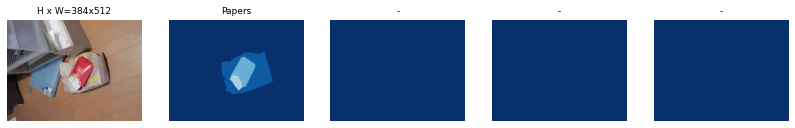

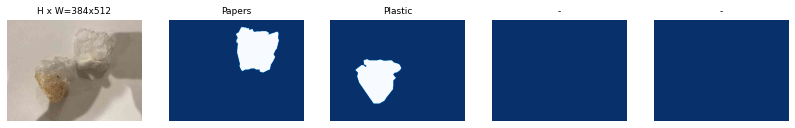

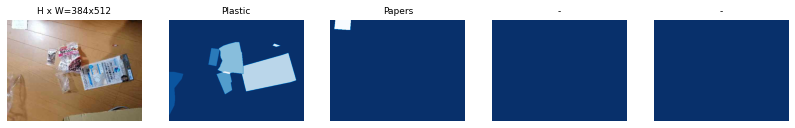

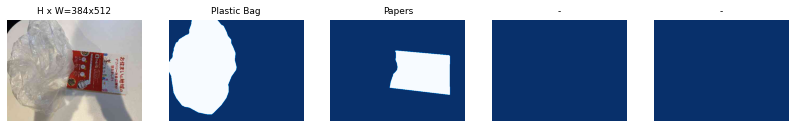

In [86]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names,4)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [87]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [88]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [89]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../../aktwelve_mask_rcnn\g_logs\gomi20201107T1328\mask_rcnn_gomi_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mas

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a 

 1/50 [..............................] - ETA: 9:53 - loss: 2.7832 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 2.2685 - mrcnn_class_loss: 0.4892 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 4:57 - loss: 4.5688 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 2.1815 - mrcnn_class_loss: 0.9617 - mrcnn_bbox_loss: 0.8086 - mrcnn_mask_loss: 0.5427        

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 3:18 - loss: 4.7347 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.9264 - mrcnn_class_loss: 1.0051 - mrcnn_bbox_loss: 0.9071 - mrcnn_mask_loss: 0.8301

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 2:29 - loss: 4.3065 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.8037 - mrcnn_class_loss: 0.8137 - mrcnn_bbox_loss: 0.8646 - mrcnn_mask_loss: 0.7412

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 1:59 - loss: 4.2582 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.8371 - mrcnn_class_loss: 0.7283 - mrcnn_bbox_loss: 0.8798 - mrcnn_mask_loss: 0.7381

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 1:38 - loss: 4.2060 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.6395 - mrcnn_class_loss: 0.7267 - mrcnn_bbox_loss: 0.8538 - mrcnn_mask_loss: 0.9173

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 1:24 - loss: 4.1826 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.5765 - mrcnn_class_loss: 0.7200 - mrcnn_bbox_loss: 0.8713 - mrcnn_mask_loss: 0.9385

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 1:13 - loss: 4.0370 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.5068 - mrcnn_class_loss: 0.6331 - mrcnn_bbox_loss: 0.9123 - mrcnn_mask_loss: 0.9133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 1:05 - loss: 3.8806 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.3882 - mrcnn_class_loss: 0.6213 - mrcnn_bbox_loss: 0.8843 - mrcnn_mask_loss: 0.9194

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 58s - loss: 3.9084 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.6602 - mrcnn_class_loss: 0.5592 - mrcnn_bbox_loss: 0.7958 - mrcnn_mask_loss: 0.8275 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 52s - loss: 3.8457 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.7952 - mrcnn_class_loss: 0.5084 - mrcnn_bbox_loss: 0.7235 - mrcnn_mask_loss: 0.7522

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 47s - loss: 3.8521 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.7046 - mrcnn_class_loss: 0.5487 - mrcnn_bbox_loss: 0.7830 - mrcnn_mask_loss: 0.7503

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 43s - loss: 3.9642 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.9742 - mrcnn_class_loss: 0.5065 - mrcnn_bbox_loss: 0.7227 - mrcnn_mask_loss: 0.6926

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 40s - loss: 3.9329 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 2.0835 - mrcnn_class_loss: 0.4704 - mrcnn_bbox_loss: 0.6711 - mrcnn_mask_loss: 0.6431

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 36s - loss: 4.0009 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 2.0798 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.7714 - mrcnn_mask_loss: 0.6460

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 34s - loss: 4.0138 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 2.0596 - mrcnn_class_loss: 0.4429 - mrcnn_bbox_loss: 0.8028 - mrcnn_mask_loss: 0.6493

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 31s - loss: 3.9542 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 2.1115 - mrcnn_class_loss: 0.4168 - mrcnn_bbox_loss: 0.7555 - mrcnn_mask_loss: 0.6111

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 29s - loss: 3.9566 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 2.0667 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.7594 - mrcnn_mask_loss: 0.6166

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 27s - loss: 3.9467 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 2.0543 - mrcnn_class_loss: 0.4614 - mrcnn_bbox_loss: 0.7533 - mrcnn_mask_loss: 0.6206

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 25s - loss: 3.9313 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 2.0123 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 0.7617 - mrcnn_mask_loss: 0.6242

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 24s - loss: 3.9722 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 2.0225 - mrcnn_class_loss: 0.4851 - mrcnn_bbox_loss: 0.7825 - mrcnn_mask_loss: 0.6280

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 22s - loss: 3.9541 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.9849 - mrcnn_class_loss: 0.4984 - mrcnn_bbox_loss: 0.7860 - mrcnn_mask_loss: 0.6311

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 21s - loss: 3.9544 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.9477 - mrcnn_class_loss: 0.5244 - mrcnn_bbox_loss: 0.7971 - mrcnn_mask_loss: 0.6336

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 19s - loss: 4.0074 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.9489 - mrcnn_class_loss: 0.5712 - mrcnn_bbox_loss: 0.8003 - mrcnn_mask_loss: 0.6365

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 18s - loss: 4.0062 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.9591 - mrcnn_class_loss: 0.5583 - mrcnn_bbox_loss: 0.7965 - mrcnn_mask_loss: 0.6394

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 17s - loss: 4.0451 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.9974 - mrcnn_class_loss: 0.5542 - mrcnn_bbox_loss: 0.7968 - mrcnn_mask_loss: 0.6416

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 16s - loss: 4.0359 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.9949 - mrcnn_class_loss: 0.5553 - mrcnn_bbox_loss: 0.7879 - mrcnn_mask_loss: 0.6438

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 15s - loss: 4.1084 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.9926 - mrcnn_class_loss: 0.5918 - mrcnn_bbox_loss: 0.8266 - mrcnn_mask_loss: 0.6448

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 14s - loss: 4.0881 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.9641 - mrcnn_class_loss: 0.6050 - mrcnn_bbox_loss: 0.8211 - mrcnn_mask_loss: 0.6463

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 13s - loss: 4.1237 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.9607 - mrcnn_class_loss: 0.6385 - mrcnn_bbox_loss: 0.8247 - mrcnn_mask_loss: 0.6478

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 12s - loss: 4.1025 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.9361 - mrcnn_class_loss: 0.6410 - mrcnn_bbox_loss: 0.8248 - mrcnn_mask_loss: 0.6492

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 11s - loss: 4.0731 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.9314 - mrcnn_class_loss: 0.6227 - mrcnn_bbox_loss: 0.8170 - mrcnn_mask_loss: 0.6509

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 10s - loss: 4.0455 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.9019 - mrcnn_class_loss: 0.6254 - mrcnn_bbox_loss: 0.8154 - mrcnn_mask_loss: 0.6523

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 9s - loss: 4.0194 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.8703 - mrcnn_class_loss: 0.6301 - mrcnn_bbox_loss: 0.8156 - mrcnn_mask_loss: 0.6536 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 9s - loss: 4.0034 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.8601 - mrcnn_class_loss: 0.6295 - mrcnn_bbox_loss: 0.8101 - mrcnn_mask_loss: 0.6543

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 8s - loss: 4.0125 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.9265 - mrcnn_class_loss: 0.6120 - mrcnn_bbox_loss: 0.7876 - mrcnn_mask_loss: 0.6362

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 7s - loss: 4.0143 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.9458 - mrcnn_class_loss: 0.5978 - mrcnn_bbox_loss: 0.7837 - mrcnn_mask_loss: 0.6374

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 6s - loss: 3.9708 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.9064 - mrcnn_class_loss: 0.5957 - mrcnn_bbox_loss: 0.7814 - mrcnn_mask_loss: 0.6389

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 6s - loss: 3.9405 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.8825 - mrcnn_class_loss: 0.5909 - mrcnn_bbox_loss: 0.7795 - mrcnn_mask_loss: 0.6398

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 5s - loss: 3.9792 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.9270 - mrcnn_class_loss: 0.5800 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.6411

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 5s - loss: 3.9546 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.9062 - mrcnn_class_loss: 0.5778 - mrcnn_bbox_loss: 0.7807 - mrcnn_mask_loss: 0.6423

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 4s - loss: 3.9462 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 1.9030 - mrcnn_class_loss: 0.5665 - mrcnn_bbox_loss: 0.7870 - mrcnn_mask_loss: 0.6429

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 3s - loss: 3.9721 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.9282 - mrcnn_class_loss: 0.5565 - mrcnn_bbox_loss: 0.7975 - mrcnn_mask_loss: 0.6435

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 3s - loss: 3.9650 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.9144 - mrcnn_class_loss: 0.5474 - mrcnn_bbox_loss: 0.8124 - mrcnn_mask_loss: 0.6445

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 2s - loss: 3.9615 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.9077 - mrcnn_class_loss: 0.5408 - mrcnn_bbox_loss: 0.8216 - mrcnn_mask_loss: 0.6457

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 2s - loss: 3.9377 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.8888 - mrcnn_class_loss: 0.5442 - mrcnn_bbox_loss: 0.8137 - mrcnn_mask_loss: 0.6459

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 1s - loss: 3.9258 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.9185 - mrcnn_class_loss: 0.5326 - mrcnn_bbox_loss: 0.7964 - mrcnn_mask_loss: 0.6322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 1s - loss: 3.9066 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.9141 - mrcnn_class_loss: 0.5240 - mrcnn_bbox_loss: 0.7906 - mrcnn_mask_loss: 0.6325

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 3.9078 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.8987 - mrcnn_class_loss: 0.5392 - mrcnn_bbox_loss: 0.7913 - mrcnn_mask_loss: 0.6337

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 1:48 - loss: 3.8025 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.2150 - mrcnn_class_loss: 0.7262 - mrcnn_bbox_loss: 1.1770 - mrcnn_mask_loss: 0.6662

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 57s - loss: 4.2232 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 1.5579 - mrcnn_class_loss: 0.9671 - mrcnn_bbox_loss: 0.9992 - mrcnn_mask_loss: 0.6814 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 161s 3s/step - loss: 3.9234 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.9061 - mrcnn_class_loss: 0.5525 - mrcnn_bbox_loss: 0.7856 - mrcnn_mask_loss: 0.6347 - val_loss: 4.2188 - val_rpn_class_loss: 0.0211 - val_rpn_bbox_loss: 1.5468 - val_mrcnn_class_loss: 0.9976 - val_mrcnn_bbox_loss: 0.9739 - val_mrcnn_mask_loss: 0.6794
Epoch 2/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 3.4270 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.0861 - mrcnn_class_loss: 0.8870 - mrcnn_bbox_loss: 0.7392 - mrcnn_mask_loss: 0.6763

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 2.9682 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 1.1979 - mrcnn_class_loss: 0.5568 - mrcnn_bbox_loss: 0.5416 - mrcnn_mask_loss: 0.6437

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 3.4286 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.2485 - mrcnn_class_loss: 0.8252 - mrcnn_bbox_loss: 0.6563 - mrcnn_mask_loss: 0.6448

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 3.2988 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.1228 - mrcnn_class_loss: 0.7750 - mrcnn_bbox_loss: 0.6985 - mrcnn_mask_loss: 0.6528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 3.2938 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.1503 - mrcnn_class_loss: 0.7482 - mrcnn_bbox_loss: 0.6940 - mrcnn_mask_loss: 0.6569

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 3.3800 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.1721 - mrcnn_class_loss: 0.7787 - mrcnn_bbox_loss: 0.7367 - mrcnn_mask_loss: 0.6531

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 3.6191 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.3156 - mrcnn_class_loss: 0.8458 - mrcnn_bbox_loss: 0.7603 - mrcnn_mask_loss: 0.6567

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 10s - loss: 3.4958 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.2069 - mrcnn_class_loss: 0.8457 - mrcnn_bbox_loss: 0.7445 - mrcnn_mask_loss: 0.6617

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 3.6112 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.3718 - mrcnn_class_loss: 0.8021 - mrcnn_bbox_loss: 0.7417 - mrcnn_mask_loss: 0.6603

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 3.6681 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.4576 - mrcnn_class_loss: 0.7810 - mrcnn_bbox_loss: 0.7329 - mrcnn_mask_loss: 0.6611

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 3.6578 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.4360 - mrcnn_class_loss: 0.8127 - mrcnn_bbox_loss: 0.7208 - mrcnn_mask_loss: 0.6545

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 3.6689 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.3793 - mrcnn_class_loss: 0.8622 - mrcnn_bbox_loss: 0.7350 - mrcnn_mask_loss: 0.6576

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 3.6434 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.3158 - mrcnn_class_loss: 0.8895 - mrcnn_bbox_loss: 0.7453 - mrcnn_mask_loss: 0.6577 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 3.6444 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.2891 - mrcnn_class_loss: 0.9187 - mrcnn_bbox_loss: 0.7400 - mrcnn_mask_loss: 0.6602

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 3.7252 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.3817 - mrcnn_class_loss: 0.8950 - mrcnn_bbox_loss: 0.7458 - mrcnn_mask_loss: 0.6622

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 8s - loss: 3.7298 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.4193 - mrcnn_class_loss: 0.8770 - mrcnn_bbox_loss: 0.7314 - mrcnn_mask_loss: 0.6626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 3.6821 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 1.3923 - mrcnn_class_loss: 0.8645 - mrcnn_bbox_loss: 0.7259 - mrcnn_mask_loss: 0.6616

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 3.6182 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.3618 - mrcnn_class_loss: 0.8454 - mrcnn_bbox_loss: 0.7130 - mrcnn_mask_loss: 0.6616

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 3.5607 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.3208 - mrcnn_class_loss: 0.8265 - mrcnn_bbox_loss: 0.7173 - mrcnn_mask_loss: 0.6614

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 7s - loss: 3.5632 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.3222 - mrcnn_class_loss: 0.8355 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.6603

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 3.5204 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.2824 - mrcnn_class_loss: 0.8207 - mrcnn_bbox_loss: 0.7229 - mrcnn_mask_loss: 0.6600

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 3.5258 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.3475 - mrcnn_class_loss: 0.7858 - mrcnn_bbox_loss: 0.6982 - mrcnn_mask_loss: 0.6604

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 3.5300 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 1.3232 - mrcnn_class_loss: 0.8065 - mrcnn_bbox_loss: 0.7058 - mrcnn_mask_loss: 0.6613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 6s - loss: 3.5369 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.3339 - mrcnn_class_loss: 0.8016 - mrcnn_bbox_loss: 0.7101 - mrcnn_mask_loss: 0.6582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 3.5544 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.3729 - mrcnn_class_loss: 0.7896 - mrcnn_bbox_loss: 0.7010 - mrcnn_mask_loss: 0.6581

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 3.4821 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 1.3265 - mrcnn_class_loss: 0.7720 - mrcnn_bbox_loss: 0.6949 - mrcnn_mask_loss: 0.6570

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 3.5035 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.3449 - mrcnn_class_loss: 0.7799 - mrcnn_bbox_loss: 0.6882 - mrcnn_mask_loss: 0.6591

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 3.5211 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.3578 - mrcnn_class_loss: 0.7768 - mrcnn_bbox_loss: 0.6999 - mrcnn_mask_loss: 0.6549

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 3.5286 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 1.3446 - mrcnn_class_loss: 0.7997 - mrcnn_bbox_loss: 0.6984 - mrcnn_mask_loss: 0.6538

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 3.5045 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.3346 - mrcnn_class_loss: 0.7860 - mrcnn_bbox_loss: 0.6967 - mrcnn_mask_loss: 0.6531

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 4s - loss: 3.5159 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.3603 - mrcnn_class_loss: 0.7711 - mrcnn_bbox_loss: 0.6969 - mrcnn_mask_loss: 0.6537

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 3.5118 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.3756 - mrcnn_class_loss: 0.7556 - mrcnn_bbox_loss: 0.6964 - mrcnn_mask_loss: 0.6511

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 3.5019 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.3536 - mrcnn_class_loss: 0.7631 - mrcnn_bbox_loss: 0.7012 - mrcnn_mask_loss: 0.6502

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 3.5024 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 1.3513 - mrcnn_class_loss: 0.7682 - mrcnn_bbox_loss: 0.6992 - mrcnn_mask_loss: 0.6495

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 3s - loss: 3.4999 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.3525 - mrcnn_class_loss: 0.7640 - mrcnn_bbox_loss: 0.7013 - mrcnn_mask_loss: 0.6482

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 3.4831 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.3408 - mrcnn_class_loss: 0.7616 - mrcnn_bbox_loss: 0.6996 - mrcnn_mask_loss: 0.6475

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 3.4379 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.3084 - mrcnn_class_loss: 0.7608 - mrcnn_bbox_loss: 0.6896 - mrcnn_mask_loss: 0.6461

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 3.4370 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.3008 - mrcnn_class_loss: 0.7702 - mrcnn_bbox_loss: 0.6882 - mrcnn_mask_loss: 0.6446

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 3.4045 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.2786 - mrcnn_class_loss: 0.7708 - mrcnn_bbox_loss: 0.6808 - mrcnn_mask_loss: 0.6418

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 3.4269 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.2946 - mrcnn_class_loss: 0.7762 - mrcnn_bbox_loss: 0.6819 - mrcnn_mask_loss: 0.6416

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 3.4406 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 1.3121 - mrcnn_class_loss: 0.7686 - mrcnn_bbox_loss: 0.6860 - mrcnn_mask_loss: 0.6413

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 3.4365 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.3102 - mrcnn_class_loss: 0.7683 - mrcnn_bbox_loss: 0.6844 - mrcnn_mask_loss: 0.6406

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 3.4301 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.3146 - mrcnn_class_loss: 0.7623 - mrcnn_bbox_loss: 0.6816 - mrcnn_mask_loss: 0.6389

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 3.4032 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 1.3003 - mrcnn_class_loss: 0.7523 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.6373

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 3.4140 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 1.3016 - mrcnn_class_loss: 0.7601 - mrcnn_bbox_loss: 0.6822 - mrcnn_mask_loss: 0.6376

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 3.4069 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.2933 - mrcnn_class_loss: 0.7604 - mrcnn_bbox_loss: 0.6843 - mrcnn_mask_loss: 0.6369

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 3.3927 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.2861 - mrcnn_class_loss: 0.7555 - mrcnn_bbox_loss: 0.6830 - mrcnn_mask_loss: 0.6361

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 3.3664 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.2755 - mrcnn_class_loss: 0.7489 - mrcnn_bbox_loss: 0.6761 - mrcnn_mask_loss: 0.6340

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 3.3566 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.2815 - mrcnn_class_loss: 0.7388 - mrcnn_bbox_loss: 0.6729 - mrcnn_mask_loss: 0.6315

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 2.6553 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 1.0268 - mrcnn_class_loss: 0.4690 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.5930

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 2.6172 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 1.2530 - mrcnn_class_loss: 0.3957 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.5428

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 3.6867 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 1.6929 - mrcnn_class_loss: 0.8050 - mrcnn_bbox_loss: 0.6075 - mrcnn_mask_loss: 0.5468 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 3.4911 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.6041 - mrcnn_class_loss: 0.7624 - mrcnn_bbox_loss: 0.5597 - mrcnn_mask_loss: 0.5322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 304ms/step - loss: 3.3536 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 0.7438 - mrcnn_bbox_loss: 0.6693 - mrcnn_mask_loss: 0.6281 - val_loss: 3.4911 - val_rpn_class_loss: 0.0327 - val_rpn_bbox_loss: 1.6041 - val_mrcnn_class_loss: 0.7624 - val_mrcnn_bbox_loss: 0.5597 - val_mrcnn_mask_loss: 0.5322
Epoch 3/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 2.0300 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6602 - mrcnn_class_loss: 0.3736 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.5517

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 2.8407 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.9788 - mrcnn_class_loss: 0.5894 - mrcnn_bbox_loss: 0.6653 - mrcnn_mask_loss: 0.5721

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 3.1750 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.1069 - mrcnn_class_loss: 0.8007 - mrcnn_bbox_loss: 0.6200 - mrcnn_mask_loss: 0.6209

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 3.1926 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 1.1010 - mrcnn_class_loss: 0.8063 - mrcnn_bbox_loss: 0.5986 - mrcnn_mask_loss: 0.6623

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 13s - loss: 3.2626 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 1.0482 - mrcnn_class_loss: 0.9095 - mrcnn_bbox_loss: 0.6150 - mrcnn_mask_loss: 0.6602

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 3.0727 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.0262 - mrcnn_class_loss: 0.7996 - mrcnn_bbox_loss: 0.5683 - mrcnn_mask_loss: 0.6483

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 2.9070 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 1.0045 - mrcnn_class_loss: 0.7107 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.6402

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 2.8083 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.9946 - mrcnn_class_loss: 0.6297 - mrcnn_bbox_loss: 0.5156 - mrcnn_mask_loss: 0.6385

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 2.7589 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.9384 - mrcnn_class_loss: 0.6468 - mrcnn_bbox_loss: 0.5167 - mrcnn_mask_loss: 0.6265

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 2.6852 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.8854 - mrcnn_class_loss: 0.6192 - mrcnn_bbox_loss: 0.5351 - mrcnn_mask_loss: 0.6129

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 2.6885 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.9205 - mrcnn_class_loss: 0.6010 - mrcnn_bbox_loss: 0.5306 - mrcnn_mask_loss: 0.6051

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 2.7133 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.9051 - mrcnn_class_loss: 0.6422 - mrcnn_bbox_loss: 0.5257 - mrcnn_mask_loss: 0.6098

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 2.7437 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.9486 - mrcnn_class_loss: 0.6304 - mrcnn_bbox_loss: 0.5304 - mrcnn_mask_loss: 0.6044

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 2.6743 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.9018 - mrcnn_class_loss: 0.6278 - mrcnn_bbox_loss: 0.5225 - mrcnn_mask_loss: 0.5931 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 2.6519 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.8889 - mrcnn_class_loss: 0.6215 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.5881

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 2.6173 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.8601 - mrcnn_class_loss: 0.6258 - mrcnn_bbox_loss: 0.5227 - mrcnn_mask_loss: 0.5817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 2.6790 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.9377 - mrcnn_class_loss: 0.6154 - mrcnn_bbox_loss: 0.5203 - mrcnn_mask_loss: 0.5784

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 2.6878 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.9231 - mrcnn_class_loss: 0.6205 - mrcnn_bbox_loss: 0.5339 - mrcnn_mask_loss: 0.5825

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 2.7121 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.9571 - mrcnn_class_loss: 0.6111 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.5807

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 2.6789 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.9661 - mrcnn_class_loss: 0.5871 - mrcnn_bbox_loss: 0.5252 - mrcnn_mask_loss: 0.5733

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 2.7210 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.9956 - mrcnn_class_loss: 0.5953 - mrcnn_bbox_loss: 0.5317 - mrcnn_mask_loss: 0.5717

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 2.7037 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.9788 - mrcnn_class_loss: 0.5946 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.5677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 2.7590 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0389 - mrcnn_class_loss: 0.5789 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.5738

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 2.7596 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.0526 - mrcnn_class_loss: 0.5768 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.5691

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 2.7525 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.0711 - mrcnn_class_loss: 0.5577 - mrcnn_bbox_loss: 0.5374 - mrcnn_mask_loss: 0.5617

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 2.7941 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.0732 - mrcnn_class_loss: 0.5825 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.5679

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 2.7946 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0785 - mrcnn_class_loss: 0.5777 - mrcnn_bbox_loss: 0.5481 - mrcnn_mask_loss: 0.5652

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 2.7914 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.0964 - mrcnn_class_loss: 0.5626 - mrcnn_bbox_loss: 0.5441 - mrcnn_mask_loss: 0.5638

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 2.8248 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 1.1096 - mrcnn_class_loss: 0.5665 - mrcnn_bbox_loss: 0.5570 - mrcnn_mask_loss: 0.5667

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 2.8420 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.1097 - mrcnn_class_loss: 0.5811 - mrcnn_bbox_loss: 0.5600 - mrcnn_mask_loss: 0.5648

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 2.8528 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 1.0928 - mrcnn_class_loss: 0.5985 - mrcnn_bbox_loss: 0.5673 - mrcnn_mask_loss: 0.5677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 2.8469 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 1.0990 - mrcnn_class_loss: 0.5986 - mrcnn_bbox_loss: 0.5612 - mrcnn_mask_loss: 0.5620

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 2.8288 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 1.0770 - mrcnn_class_loss: 0.6034 - mrcnn_bbox_loss: 0.5624 - mrcnn_mask_loss: 0.5596

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 2.8172 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.0888 - mrcnn_class_loss: 0.5943 - mrcnn_bbox_loss: 0.5541 - mrcnn_mask_loss: 0.5539

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 2.7769 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 1.0697 - mrcnn_class_loss: 0.5870 - mrcnn_bbox_loss: 0.5463 - mrcnn_mask_loss: 0.5483

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 2.7752 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 1.0617 - mrcnn_class_loss: 0.5898 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.5497

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 2.7511 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.0427 - mrcnn_class_loss: 0.5938 - mrcnn_bbox_loss: 0.5441 - mrcnn_mask_loss: 0.5456

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 2.7367 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.0508 - mrcnn_class_loss: 0.5875 - mrcnn_bbox_loss: 0.5343 - mrcnn_mask_loss: 0.5394

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 2.7153 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.0565 - mrcnn_class_loss: 0.5750 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.5313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 2.7165 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.0565 - mrcnn_class_loss: 0.5777 - mrcnn_bbox_loss: 0.5297 - mrcnn_mask_loss: 0.5277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 2.6904 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.0484 - mrcnn_class_loss: 0.5671 - mrcnn_bbox_loss: 0.5281 - mrcnn_mask_loss: 0.5223

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 2.6890 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 1.0443 - mrcnn_class_loss: 0.5656 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.5216

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 2.6559 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.0262 - mrcnn_class_loss: 0.5554 - mrcnn_bbox_loss: 0.5307 - mrcnn_mask_loss: 0.5189

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 2.6407 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.0212 - mrcnn_class_loss: 0.5472 - mrcnn_bbox_loss: 0.5353 - mrcnn_mask_loss: 0.5125

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 2.6484 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 1.0357 - mrcnn_class_loss: 0.5447 - mrcnn_bbox_loss: 0.5335 - mrcnn_mask_loss: 0.5102

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 2.7103 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.0763 - mrcnn_class_loss: 0.5395 - mrcnn_bbox_loss: 0.5340 - mrcnn_mask_loss: 0.5353

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 2.6838 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 1.0714 - mrcnn_class_loss: 0.5306 - mrcnn_bbox_loss: 0.5291 - mrcnn_mask_loss: 0.5279

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 2.6469 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 1.0525 - mrcnn_class_loss: 0.5257 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.5211

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 2.6720 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 1.0907 - mrcnn_class_loss: 0.5200 - mrcnn_bbox_loss: 0.5208 - mrcnn_mask_loss: 0.5159

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 3.8145 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.6686 - mrcnn_class_loss: 0.8326 - mrcnn_bbox_loss: 0.7613 - mrcnn_mask_loss: 0.4989

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 4.0931 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.8805 - mrcnn_class_loss: 1.0304 - mrcnn_bbox_loss: 0.7175 - mrcnn_mask_loss: 0.4254

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 3.5844 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.6433 - mrcnn_class_loss: 0.8440 - mrcnn_bbox_loss: 0.6711 - mrcnn_mask_loss: 0.3933 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 305ms/step - loss: 2.6503 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 1.0838 - mrcnn_class_loss: 0.5154 - mrcnn_bbox_loss: 0.5175 - mrcnn_mask_loss: 0.5092 - val_loss: 3.5467 - val_rpn_class_loss: 0.0280 - val_rpn_bbox_loss: 1.6885 - val_mrcnn_class_loss: 0.8132 - val_mrcnn_bbox_loss: 0.6266 - val_mrcnn_mask_loss: 0.3904
Epoch 4/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 2.6617 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9081 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 1.1179 - mrcnn_mask_loss: 0.3979

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 2.5258 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.8829 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.9766 - mrcnn_mask_loss: 0.3859

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 2.1893 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7959 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.8004 - mrcnn_mask_loss: 0.3803

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 2.1443 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.7476 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.6936 - mrcnn_mask_loss: 0.3753

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 2.2618 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8978 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.6282 - mrcnn_mask_loss: 0.4069

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 2.5041 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.1108 - mrcnn_class_loss: 0.3134 - mrcnn_bbox_loss: 0.6381 - mrcnn_mask_loss: 0.4035

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 2.5215 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.1627 - mrcnn_class_loss: 0.3278 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.4036

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 2.5761 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.1272 - mrcnn_class_loss: 0.3849 - mrcnn_bbox_loss: 0.5863 - mrcnn_mask_loss: 0.4410

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 2.6229 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.1607 - mrcnn_class_loss: 0.4055 - mrcnn_bbox_loss: 0.5869 - mrcnn_mask_loss: 0.4312

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 2.5338 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.1041 - mrcnn_class_loss: 0.4028 - mrcnn_bbox_loss: 0.5675 - mrcnn_mask_loss: 0.4231

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 2.5204 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.0927 - mrcnn_class_loss: 0.4125 - mrcnn_bbox_loss: 0.5589 - mrcnn_mask_loss: 0.4212

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 2.3967 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.0174 - mrcnn_class_loss: 0.3976 - mrcnn_bbox_loss: 0.5413 - mrcnn_mask_loss: 0.4076

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 2.5719 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.1142 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.5483 - mrcnn_mask_loss: 0.4168 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 2.6416 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 1.1653 - mrcnn_class_loss: 0.4824 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.4158

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 2.5729 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 1.1111 - mrcnn_class_loss: 0.4652 - mrcnn_bbox_loss: 0.5444 - mrcnn_mask_loss: 0.4199

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 2.5683 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.1272 - mrcnn_class_loss: 0.4529 - mrcnn_bbox_loss: 0.5442 - mrcnn_mask_loss: 0.4126

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 2.5481 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.1079 - mrcnn_class_loss: 0.4642 - mrcnn_bbox_loss: 0.5329 - mrcnn_mask_loss: 0.4116

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 2.4984 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 1.0729 - mrcnn_class_loss: 0.4560 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.4109

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 2.6083 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 1.1184 - mrcnn_class_loss: 0.5010 - mrcnn_bbox_loss: 0.5388 - mrcnn_mask_loss: 0.4203

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 2.5893 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 1.0887 - mrcnn_class_loss: 0.5117 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.4178

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 2.5637 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 1.0731 - mrcnn_class_loss: 0.5118 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4164

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 2.5729 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.0623 - mrcnn_class_loss: 0.5264 - mrcnn_bbox_loss: 0.5336 - mrcnn_mask_loss: 0.4199

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 2.5360 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.0316 - mrcnn_class_loss: 0.5288 - mrcnn_bbox_loss: 0.5316 - mrcnn_mask_loss: 0.4125

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 2.4993 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 1.0028 - mrcnn_class_loss: 0.5322 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.4065

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 2.5346 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.0237 - mrcnn_class_loss: 0.5364 - mrcnn_bbox_loss: 0.5308 - mrcnn_mask_loss: 0.4121

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 2.4974 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.9926 - mrcnn_class_loss: 0.5390 - mrcnn_bbox_loss: 0.5285 - mrcnn_mask_loss: 0.4066

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 2.4796 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.9762 - mrcnn_class_loss: 0.5441 - mrcnn_bbox_loss: 0.5218 - mrcnn_mask_loss: 0.4062

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 2.4702 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.9776 - mrcnn_class_loss: 0.5398 - mrcnn_bbox_loss: 0.5183 - mrcnn_mask_loss: 0.4040

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 2.4550 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.9657 - mrcnn_class_loss: 0.5405 - mrcnn_bbox_loss: 0.5188 - mrcnn_mask_loss: 0.4002

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 2.4949 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.0004 - mrcnn_class_loss: 0.5464 - mrcnn_bbox_loss: 0.5183 - mrcnn_mask_loss: 0.4005

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 2.4813 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.9934 - mrcnn_class_loss: 0.5424 - mrcnn_bbox_loss: 0.5175 - mrcnn_mask_loss: 0.3992

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 2.4593 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.9793 - mrcnn_class_loss: 0.5391 - mrcnn_bbox_loss: 0.5146 - mrcnn_mask_loss: 0.3970

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 2.4785 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.9891 - mrcnn_class_loss: 0.5530 - mrcnn_bbox_loss: 0.5130 - mrcnn_mask_loss: 0.3946

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 2.4787 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 1.0070 - mrcnn_class_loss: 0.5492 - mrcnn_bbox_loss: 0.5054 - mrcnn_mask_loss: 0.3889

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 2.4449 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.9829 - mrcnn_class_loss: 0.5493 - mrcnn_bbox_loss: 0.5007 - mrcnn_mask_loss: 0.3844

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 2.4570 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 1.0150 - mrcnn_class_loss: 0.5403 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.3786

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 2.4745 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 1.0271 - mrcnn_class_loss: 0.5459 - mrcnn_bbox_loss: 0.4962 - mrcnn_mask_loss: 0.3783

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 2.4405 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 1.0060 - mrcnn_class_loss: 0.5442 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.3724

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 2.4271 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.9893 - mrcnn_class_loss: 0.5519 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.3704

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 2.4034 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.9730 - mrcnn_class_loss: 0.5517 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.3661

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 2.4230 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.9918 - mrcnn_class_loss: 0.5542 - mrcnn_bbox_loss: 0.4851 - mrcnn_mask_loss: 0.3646

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 2.4377 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.9849 - mrcnn_class_loss: 0.5623 - mrcnn_bbox_loss: 0.4935 - mrcnn_mask_loss: 0.3696

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 2.4110 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.9750 - mrcnn_class_loss: 0.5531 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.3676

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 2.4150 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.9952 - mrcnn_class_loss: 0.5469 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.3638

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 2.4288 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 1.0023 - mrcnn_class_loss: 0.5468 - mrcnn_bbox_loss: 0.4841 - mrcnn_mask_loss: 0.3679

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 2.4174 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.9991 - mrcnn_class_loss: 0.5402 - mrcnn_bbox_loss: 0.4821 - mrcnn_mask_loss: 0.3685

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 2.3870 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.9810 - mrcnn_class_loss: 0.5338 - mrcnn_bbox_loss: 0.4810 - mrcnn_mask_loss: 0.3636

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 2.3906 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.9762 - mrcnn_class_loss: 0.5357 - mrcnn_bbox_loss: 0.4761 - mrcnn_mask_loss: 0.3753

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 2.4106 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0020 - mrcnn_class_loss: 0.5384 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.3728

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 4.2106 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.7459 - mrcnn_class_loss: 1.6198 - mrcnn_bbox_loss: 0.5937 - mrcnn_mask_loss: 0.2345

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 3.4783 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 1.0754 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.3918

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.9706 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.1997 - mrcnn_class_loss: 0.8697 - mrcnn_bbox_loss: 0.5080 - mrcnn_mask_loss: 0.3711 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 313ms/step - loss: 2.4393 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 1.0242 - mrcnn_class_loss: 0.5345 - mrcnn_bbox_loss: 0.4756 - mrcnn_mask_loss: 0.3779 - val_loss: 2.8908 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 1.1933 - val_mrcnn_class_loss: 0.8364 - val_mrcnn_bbox_loss: 0.5004 - val_mrcnn_mask_loss: 0.3410
Epoch 5/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 1.8755 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 1.0435 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.2624

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 3.1397 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.6290 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.6284 - mrcnn_mask_loss: 0.6449

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 3.0093 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 1.5663 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.5840 - mrcnn_mask_loss: 0.5991

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 2.7731 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 1.4456 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.5296 - mrcnn_mask_loss: 0.5361

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 2.4732 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 1.2346 - mrcnn_class_loss: 0.2923 - mrcnn_bbox_loss: 0.4594 - mrcnn_mask_loss: 0.4734

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 2.4464 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.2115 - mrcnn_class_loss: 0.3368 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.4431

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 2.2276 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.0688 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.4065 - mrcnn_mask_loss: 0.4134

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 2.3871 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.0459 - mrcnn_class_loss: 0.4224 - mrcnn_bbox_loss: 0.4532 - mrcnn_mask_loss: 0.4465

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 2.3114 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.0081 - mrcnn_class_loss: 0.4243 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.4272

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 2.4545 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.1252 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.4300

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 2.5070 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 1.2254 - mrcnn_class_loss: 0.4017 - mrcnn_bbox_loss: 0.4379 - mrcnn_mask_loss: 0.4244

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 2.4901 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.2535 - mrcnn_class_loss: 0.3697 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.4138

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 2.5748 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.3193 - mrcnn_class_loss: 0.3619 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_loss: 0.4269

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 2.5877 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 1.3035 - mrcnn_class_loss: 0.3960 - mrcnn_bbox_loss: 0.4442 - mrcnn_mask_loss: 0.4261 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 2.5737 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.2506 - mrcnn_class_loss: 0.4222 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.4325

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 2.5760 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.2334 - mrcnn_class_loss: 0.4556 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.4325

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 2.5840 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.2433 - mrcnn_class_loss: 0.4638 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.4292

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 2.6082 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 1.2263 - mrcnn_class_loss: 0.4756 - mrcnn_bbox_loss: 0.4459 - mrcnn_mask_loss: 0.4430

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 2.5536 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 1.2103 - mrcnn_class_loss: 0.4544 - mrcnn_bbox_loss: 0.4373 - mrcnn_mask_loss: 0.4341

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 2.4938 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 1.1594 - mrcnn_class_loss: 0.4428 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.4294

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 2.4425 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 1.1122 - mrcnn_class_loss: 0.4455 - mrcnn_bbox_loss: 0.4480 - mrcnn_mask_loss: 0.4200

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 2.4806 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 1.1480 - mrcnn_class_loss: 0.4534 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.4153

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 2.5341 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 1.1976 - mrcnn_class_loss: 0.4509 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.4227

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 2.5607 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 1.2172 - mrcnn_class_loss: 0.4510 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.4279

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 2.5434 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 1.2252 - mrcnn_class_loss: 0.4423 - mrcnn_bbox_loss: 0.4356 - mrcnn_mask_loss: 0.4225

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 2.5096 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 1.2099 - mrcnn_class_loss: 0.4312 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.4157

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 2.5149 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 1.2229 - mrcnn_class_loss: 0.4286 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.4140

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 2.5023 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.2090 - mrcnn_class_loss: 0.4371 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4096

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 2.4816 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 1.2074 - mrcnn_class_loss: 0.4307 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.4015

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 2.4712 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.2025 - mrcnn_class_loss: 0.4349 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.3956

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 2.4902 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.2165 - mrcnn_class_loss: 0.4417 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.3941

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 2.4739 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.1941 - mrcnn_class_loss: 0.4440 - mrcnn_bbox_loss: 0.4218 - mrcnn_mask_loss: 0.3946

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 2.4675 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.1787 - mrcnn_class_loss: 0.4473 - mrcnn_bbox_loss: 0.4242 - mrcnn_mask_loss: 0.3973

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 2.4726 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1670 - mrcnn_class_loss: 0.4687 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.3943

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 2.4698 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.4753 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.3915

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 2.4862 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 1.1748 - mrcnn_class_loss: 0.4793 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.3901

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 2.4883 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.1852 - mrcnn_class_loss: 0.4778 - mrcnn_bbox_loss: 0.4223 - mrcnn_mask_loss: 0.3836

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 2.4852 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 1.1755 - mrcnn_class_loss: 0.4855 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.3848

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 2.4670 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 1.1586 - mrcnn_class_loss: 0.4849 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.3832

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 2.4765 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 1.1614 - mrcnn_class_loss: 0.4879 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.3840

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 2.4492 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1431 - mrcnn_class_loss: 0.4832 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.3818

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 2.4248 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1264 - mrcnn_class_loss: 0.4818 - mrcnn_bbox_loss: 0.4183 - mrcnn_mask_loss: 0.3787

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 2.4071 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 1.1160 - mrcnn_class_loss: 0.4751 - mrcnn_bbox_loss: 0.4164 - mrcnn_mask_loss: 0.3797

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 2.4117 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1344 - mrcnn_class_loss: 0.4665 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.3754

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 2.3926 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1218 - mrcnn_class_loss: 0.4637 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.3747

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 2.3709 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1155 - mrcnn_class_loss: 0.4581 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.3686

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 2.3659 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.1048 - mrcnn_class_loss: 0.4641 - mrcnn_bbox_loss: 0.4085 - mrcnn_mask_loss: 0.3689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 2.3566 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 1.0913 - mrcnn_class_loss: 0.4678 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.3703

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 2.3382 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.0808 - mrcnn_class_loss: 0.4653 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.3685

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 10s - loss: 2.9206 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.7351 - mrcnn_class_loss: 0.4155 - mrcnn_bbox_loss: 0.4643 - mrcnn_mask_loss: 0.2932

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 3.2864 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.9908 - mrcnn_class_loss: 0.3722 - mrcnn_bbox_loss: 0.6174 - mrcnn_mask_loss: 0.2965

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 3.4199 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 2.0760 - mrcnn_class_loss: 0.3666 - mrcnn_bbox_loss: 0.6684 - mrcnn_mask_loss: 0.2977 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 3.3814 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.8510 - mrcnn_class_loss: 0.5922 - mrcnn_bbox_loss: 0.6404 - mrcnn_mask_loss: 0.2883

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 313ms/step - loss: 2.3397 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.0705 - mrcnn_class_loss: 0.4690 - mrcnn_bbox_loss: 0.4068 - mrcnn_mask_loss: 0.3741 - val_loss: 3.0343 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 1.6507 - val_mrcnn_class_loss: 0.5272 - val_mrcnn_bbox_loss: 0.5784 - val_mrcnn_mask_loss: 0.2690
Epoch 6/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 1.8252 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.8103 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.2133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 1.6530 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.7776 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.4069 - mrcnn_mask_loss: 0.2175

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 1.3046 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.3279 - mrcnn_mask_loss: 0.2031

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 1.2770 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.3351 - mrcnn_mask_loss: 0.2215

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 1.1229 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3663 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.2116

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.4094 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.5784 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.2309

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.3132 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.5168 - mrcnn_class_loss: 0.2824 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.2301

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 10s - loss: 1.4438 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.2889 - mrcnn_bbox_loss: 0.2890 - mrcnn_mask_loss: 0.2370

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.4880 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.6160 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2415

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.5559 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.6206 - mrcnn_class_loss: 0.3515 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2490

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.5946 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.3329 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.2374

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.5732 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6432 - mrcnn_class_loss: 0.3280 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.2422

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.6247 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6925 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.2346 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.7205 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.7094 - mrcnn_class_loss: 0.4160 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.2365

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.7411 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.4003 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.2332

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.7850 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7384 - mrcnn_class_loss: 0.4078 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.2544

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.7620 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7144 - mrcnn_class_loss: 0.3973 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.2559

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.7841 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7333 - mrcnn_class_loss: 0.3984 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.2596

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.8034 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.3918 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.2593

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 7s - loss: 1.7852 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7383 - mrcnn_class_loss: 0.3887 - mrcnn_bbox_loss: 0.3779 - mrcnn_mask_loss: 0.2654

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.8347 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7730 - mrcnn_class_loss: 0.4025 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.2636

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.8974 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.8328 - mrcnn_class_loss: 0.3983 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.2653

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.9604 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.8763 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.2661

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 6s - loss: 1.9384 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.8691 - mrcnn_class_loss: 0.3961 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.2669

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.9667 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.9014 - mrcnn_class_loss: 0.3904 - mrcnn_bbox_loss: 0.3908 - mrcnn_mask_loss: 0.2693

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.9736 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.8976 - mrcnn_class_loss: 0.3923 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.2755

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.9461 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8741 - mrcnn_class_loss: 0.3883 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.2716

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.9761 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.9083 - mrcnn_class_loss: 0.3891 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.2707

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.9610 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.9078 - mrcnn_class_loss: 0.3778 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.2665

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.9962 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.9376 - mrcnn_class_loss: 0.3790 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.2691

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.9898 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.9291 - mrcnn_class_loss: 0.3825 - mrcnn_bbox_loss: 0.3925 - mrcnn_mask_loss: 0.2705

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 2.0372 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.9438 - mrcnn_class_loss: 0.4012 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.2774

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 2.0615 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.9629 - mrcnn_class_loss: 0.4007 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.2801

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 2.1067 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.9730 - mrcnn_class_loss: 0.4188 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.2884

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 2.0992 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.9536 - mrcnn_class_loss: 0.4316 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.2861

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 2.0888 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.9478 - mrcnn_class_loss: 0.4273 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.2876

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 2.1237 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.9694 - mrcnn_class_loss: 0.4248 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.3037

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 2.1307 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9585 - mrcnn_class_loss: 0.4353 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.3068

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 2.1097 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9449 - mrcnn_class_loss: 0.4304 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.3070

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 2.1049 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.9394 - mrcnn_class_loss: 0.4295 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.3065

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 2.1080 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.9462 - mrcnn_class_loss: 0.4301 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.3063

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 2.1205 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.9406 - mrcnn_class_loss: 0.4325 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.3103

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 2.1529 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9679 - mrcnn_class_loss: 0.4364 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.3109

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 2.1409 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.9578 - mrcnn_class_loss: 0.4340 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.3108

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 2.1432 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.9518 - mrcnn_class_loss: 0.4343 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.3154

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 2.1636 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9662 - mrcnn_class_loss: 0.4310 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.3220

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 2.1702 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9736 - mrcnn_class_loss: 0.4341 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.3210

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 2.1801 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.9936 - mrcnn_class_loss: 0.4263 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.3191

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 2.1918 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.0131 - mrcnn_class_loss: 0.4224 - mrcnn_bbox_loss: 0.4191 - mrcnn_mask_loss: 0.3190

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 2.5586 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 1.3676 - mrcnn_class_loss: 0.5396 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.2519

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 2.6860 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 1.4246 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 0.6550 - mrcnn_mask_loss: 0.2329

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.0879 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 1.0080 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.2536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 306ms/step - loss: 2.1849 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 1.0047 - mrcnn_class_loss: 0.4298 - mrcnn_bbox_loss: 0.4156 - mrcnn_mask_loss: 0.3167 - val_loss: 1.9692 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.9791 - val_mrcnn_class_loss: 0.2236 - val_mrcnn_bbox_loss: 0.5279 - val_mrcnn_mask_loss: 0.2334
Epoch 7/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 1.6506 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.9029 - mrcnn_class_loss: 0.1740 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.2608

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 1.7267 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 1.1079 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.2571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 1.6534 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.9329 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.2359

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 1.7092 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.9212 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.3418 - mrcnn_mask_loss: 0.2515

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 1.6688 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.8228 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.2668

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.5215 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.7002 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.3373 - mrcnn_mask_loss: 0.2509

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 10s - loss: 1.6731 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.9087 - mrcnn_class_loss: 0.1944 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.2342

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 10s - loss: 1.7424 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.8641 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.2600

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.7441 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.8843 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.3847 - mrcnn_mask_loss: 0.2484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 9s - loss: 1.7281 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.8837 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.3998 - mrcnn_mask_loss: 0.2382 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 9s - loss: 1.8199 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.9499 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.4113 - mrcnn_mask_loss: 0.2579

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 9s - loss: 1.8441 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.9437 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.2758

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.8189 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.9173 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.3951 - mrcnn_mask_loss: 0.2727

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.8623 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.9048 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.2760

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 8s - loss: 1.8388 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.8931 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.2645

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 8s - loss: 1.7900 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.8465 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.2548

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.7909 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.8309 - mrcnn_class_loss: 0.2943 - mrcnn_bbox_loss: 0.4077 - mrcnn_mask_loss: 0.2454

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.7886 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.8166 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.2499

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 7s - loss: 1.8115 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7970 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.2618

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 7s - loss: 1.7818 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7827 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.2549

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.8340 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.8334 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.2477

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.8332 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.8161 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.2569

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 6s - loss: 1.8053 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7907 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.2557

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 6s - loss: 1.8598 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.7826 - mrcnn_class_loss: 0.3546 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.2675

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.8587 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8045 - mrcnn_class_loss: 0.3462 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.2632

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.8855 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.8314 - mrcnn_class_loss: 0.3500 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.2613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.9669 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.8698 - mrcnn_class_loss: 0.3654 - mrcnn_bbox_loss: 0.4331 - mrcnn_mask_loss: 0.2828

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.9898 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.8823 - mrcnn_class_loss: 0.3807 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.2787

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 2.0318 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8814 - mrcnn_class_loss: 0.4066 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.2833

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 2.0362 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.8879 - mrcnn_class_loss: 0.4125 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.2800

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 4s - loss: 2.0711 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9005 - mrcnn_class_loss: 0.4282 - mrcnn_bbox_loss: 0.4389 - mrcnn_mask_loss: 0.2863

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 2.0442 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8874 - mrcnn_class_loss: 0.4188 - mrcnn_bbox_loss: 0.4389 - mrcnn_mask_loss: 0.2820

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 2.0213 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8810 - mrcnn_class_loss: 0.4120 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.2775

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 2.0120 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.8636 - mrcnn_class_loss: 0.4199 - mrcnn_bbox_loss: 0.4302 - mrcnn_mask_loss: 0.2810

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 3s - loss: 2.0132 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8594 - mrcnn_class_loss: 0.4303 - mrcnn_bbox_loss: 0.4276 - mrcnn_mask_loss: 0.2782

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 2.0405 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8919 - mrcnn_class_loss: 0.4206 - mrcnn_bbox_loss: 0.4264 - mrcnn_mask_loss: 0.2826

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 2.0435 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8923 - mrcnn_class_loss: 0.4186 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.2884

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 2.0243 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8765 - mrcnn_class_loss: 0.4235 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.2865

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 2.0085 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8669 - mrcnn_class_loss: 0.4215 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.2842

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 2.0005 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8577 - mrcnn_class_loss: 0.4245 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.2843

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 2.0121 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.8782 - mrcnn_class_loss: 0.4173 - mrcnn_bbox_loss: 0.4128 - mrcnn_mask_loss: 0.2846

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.9961 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8734 - mrcnn_class_loss: 0.4122 - mrcnn_bbox_loss: 0.4096 - mrcnn_mask_loss: 0.2819

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 2.0274 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8818 - mrcnn_class_loss: 0.4227 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.2867

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 2.0014 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8650 - mrcnn_class_loss: 0.4197 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.2852

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.9961 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8690 - mrcnn_class_loss: 0.4157 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.2837

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.9713 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8573 - mrcnn_class_loss: 0.4111 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.2806

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.9584 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8571 - mrcnn_class_loss: 0.4053 - mrcnn_bbox_loss: 0.3995 - mrcnn_mask_loss: 0.2783

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.9843 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8878 - mrcnn_class_loss: 0.4055 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.2774

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.9570 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8712 - mrcnn_class_loss: 0.4038 - mrcnn_bbox_loss: 0.3889 - mrcnn_mask_loss: 0.2751

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 3.1768 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 1.4172 - mrcnn_class_loss: 0.9158 - mrcnn_bbox_loss: 0.5806 - mrcnn_mask_loss: 0.2516 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 3.0260 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 1.4418 - mrcnn_class_loss: 0.6610 - mrcnn_bbox_loss: 0.6217 - mrcnn_mask_loss: 0.2907

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.8369 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.3419 - mrcnn_class_loss: 0.7031 - mrcnn_bbox_loss: 0.5176 - mrcnn_mask_loss: 0.2621

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 300ms/step - loss: 1.9603 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8806 - mrcnn_class_loss: 0.3984 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.2781 - val_loss: 2.8369 - val_rpn_class_loss: 0.0122 - val_rpn_bbox_loss: 1.3419 - val_mrcnn_class_loss: 0.7031 - val_mrcnn_bbox_loss: 0.5176 - val_mrcnn_mask_loss: 0.2621
Epoch 8/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 2.6906 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 2.6731 - mrcnn_class_loss: 3.5763e-07 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 1.9292 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.5120 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1662            

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 1.9761 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 1.1780 - mrcnn_class_loss: 0.3433 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.2174

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 1.7084 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.9877 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.1979

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 1.5382 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.8213 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.1990

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 10s - loss: 1.5934 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.8157 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.1968

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 10s - loss: 1.6220 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.8750 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.2116

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 10s - loss: 1.6285 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.9030 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.2012

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.5937 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.8635 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.1985

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.5921 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.2723 - mrcnn_mask_loss: 0.1991

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.6853 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.9326 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.2729 - mrcnn_mask_loss: 0.2070

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 9s - loss: 1.6732 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8915 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.2234 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.6850 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.8597 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.2352

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.6527 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8311 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2358

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.6594 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.8029 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.2403

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 8s - loss: 1.6630 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.7746 - mrcnn_class_loss: 0.3214 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.2442

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.6874 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.8144 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2358

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.7751 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.8554 - mrcnn_class_loss: 0.3326 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.2562

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.7851 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.8529 - mrcnn_class_loss: 0.3503 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.2535

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 7s - loss: 1.7528 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.8283 - mrcnn_class_loss: 0.3439 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.2542

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.7414 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8151 - mrcnn_class_loss: 0.3425 - mrcnn_bbox_loss: 0.3144 - mrcnn_mask_loss: 0.2498

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.7632 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8233 - mrcnn_class_loss: 0.3314 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.2634

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.7420 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.8072 - mrcnn_class_loss: 0.3239 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.2663

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 6s - loss: 1.7016 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.7807 - mrcnn_class_loss: 0.3204 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2607

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.7755 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.7965 - mrcnn_class_loss: 0.3518 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.2695

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.7501 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.7697 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.2674

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.7339 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.7530 - mrcnn_class_loss: 0.3478 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.2690

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.7874 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.7740 - mrcnn_class_loss: 0.3694 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.2705

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.8524 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.8171 - mrcnn_class_loss: 0.3952 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.2700

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.8696 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8402 - mrcnn_class_loss: 0.3856 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.2779

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.8287 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8138 - mrcnn_class_loss: 0.3791 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.2760

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.8600 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8058 - mrcnn_class_loss: 0.4094 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.2797

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.8523 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8118 - mrcnn_class_loss: 0.4040 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.2767

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.8972 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.4040 - mrcnn_bbox_loss: 0.3411 - mrcnn_mask_loss: 0.2806

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.9255 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8557 - mrcnn_class_loss: 0.4209 - mrcnn_bbox_loss: 0.3443 - mrcnn_mask_loss: 0.2852

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.9133 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8551 - mrcnn_class_loss: 0.4127 - mrcnn_bbox_loss: 0.3430 - mrcnn_mask_loss: 0.2835

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.9046 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8389 - mrcnn_class_loss: 0.4112 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.2866

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.9327 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8539 - mrcnn_class_loss: 0.4151 - mrcnn_bbox_loss: 0.3522 - mrcnn_mask_loss: 0.2926

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 1.9209 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8453 - mrcnn_class_loss: 0.4138 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.2925

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.9078 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.8331 - mrcnn_class_loss: 0.4136 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.2911

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.9689 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8579 - mrcnn_class_loss: 0.4366 - mrcnn_bbox_loss: 0.3584 - mrcnn_mask_loss: 0.2963

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.9855 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.8704 - mrcnn_class_loss: 0.4331 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.2988

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.9895 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.8673 - mrcnn_class_loss: 0.4419 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.2980

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.9672 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.8605 - mrcnn_class_loss: 0.4340 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.2935

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.9613 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.8661 - mrcnn_class_loss: 0.4313 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.2892

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.9375 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.8535 - mrcnn_class_loss: 0.4258 - mrcnn_bbox_loss: 0.3515 - mrcnn_mask_loss: 0.2866

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.9252 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.8440 - mrcnn_class_loss: 0.4239 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.2842

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.9329 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.8518 - mrcnn_class_loss: 0.4199 - mrcnn_bbox_loss: 0.3510 - mrcnn_mask_loss: 0.2901

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.9347 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.8493 - mrcnn_class_loss: 0.4224 - mrcnn_bbox_loss: 0.3519 - mrcnn_mask_loss: 0.2911

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 1.6287 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.1197 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.3046 - mrcnn_mask_loss: 0.0878

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.5181 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 1.5827 - mrcnn_class_loss: 0.3532 - mrcnn_bbox_loss: 0.4078 - mrcnn_mask_loss: 0.1592

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.1240 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 1.1245 - mrcnn_class_loss: 0.4281 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.1652

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 1.8695 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.9403 - mrcnn_class_loss: 0.3975 - mrcnn_bbox_loss: 0.3710 - mrcnn_mask_loss: 0.1502

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 310ms/step - loss: 1.9565 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.8496 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.2968 - val_loss: 1.8695 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.9403 - val_mrcnn_class_loss: 0.3975 - val_mrcnn_bbox_loss: 0.3710 - val_mrcnn_mask_loss: 0.1502
Epoch 9/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 1.3099 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.3621 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.2157

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 1.6479 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.6130 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.3526 - mrcnn_mask_loss: 0.2067

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 1.3341 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.5154 - mrcnn_class_loss: 0.3198 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.1761

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 1.9252 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.9810 - mrcnn_class_loss: 0.4045 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.1992

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 1.8781 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.8774 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.2505

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.7338 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.7554 - mrcnn_class_loss: 0.3543 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.2486

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.8203 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.8865 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.2267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.7577 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8269 - mrcnn_class_loss: 0.3258 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.2266

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.8585 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8281 - mrcnn_class_loss: 0.3945 - mrcnn_bbox_loss: 0.3854 - mrcnn_mask_loss: 0.2326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.7610 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.7756 - mrcnn_class_loss: 0.3731 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.2231

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.8385 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.8830 - mrcnn_class_loss: 0.3642 - mrcnn_bbox_loss: 0.3540 - mrcnn_mask_loss: 0.2183

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.9155 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.9441 - mrcnn_class_loss: 0.3735 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.2274

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.8872 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8868 - mrcnn_class_loss: 0.3767 - mrcnn_bbox_loss: 0.3608 - mrcnn_mask_loss: 0.2436 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.8474 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.8589 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.2445

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.9200 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.9246 - mrcnn_class_loss: 0.3634 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.2587

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.8879 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.8812 - mrcnn_class_loss: 0.3759 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.2613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.8553 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.8504 - mrcnn_class_loss: 0.3709 - mrcnn_bbox_loss: 0.3480 - mrcnn_mask_loss: 0.2656

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.8263 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.8282 - mrcnn_class_loss: 0.3649 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.2587

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.8820 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.8774 - mrcnn_class_loss: 0.3588 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.2658

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.8628 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.8510 - mrcnn_class_loss: 0.3666 - mrcnn_bbox_loss: 0.3550 - mrcnn_mask_loss: 0.2694

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.8666 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.8718 - mrcnn_class_loss: 0.3546 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.2734

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.8707 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.8599 - mrcnn_class_loss: 0.3729 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.2709

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.8924 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.8749 - mrcnn_class_loss: 0.3768 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.2702

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.8902 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.8600 - mrcnn_class_loss: 0.3884 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.2735

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.8363 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.8297 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.2691

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.8934 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.8861 - mrcnn_class_loss: 0.3713 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.2717

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.8887 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.8863 - mrcnn_class_loss: 0.3653 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.2703

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.8696 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.8810 - mrcnn_class_loss: 0.3569 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.2717

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.8887 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.9068 - mrcnn_class_loss: 0.3531 - mrcnn_bbox_loss: 0.3403 - mrcnn_mask_loss: 0.2690

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.8661 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.8852 - mrcnn_class_loss: 0.3595 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.2677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.8523 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.8730 - mrcnn_class_loss: 0.3605 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.2682

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.8385 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8709 - mrcnn_class_loss: 0.3555 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2672

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.8125 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8630 - mrcnn_class_loss: 0.3473 - mrcnn_bbox_loss: 0.3196 - mrcnn_mask_loss: 0.2642

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.7734 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8391 - mrcnn_class_loss: 0.3415 - mrcnn_bbox_loss: 0.3134 - mrcnn_mask_loss: 0.2613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.7724 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8477 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.2593

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.7493 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8332 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.2575

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.7428 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8203 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.2575

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.7500 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8128 - mrcnn_class_loss: 0.3483 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.2620

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 1.7719 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8293 - mrcnn_class_loss: 0.3484 - mrcnn_bbox_loss: 0.3148 - mrcnn_mask_loss: 0.2612

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.8034 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8610 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.3164 - mrcnn_mask_loss: 0.2611

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.8113 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8571 - mrcnn_class_loss: 0.3466 - mrcnn_bbox_loss: 0.3242 - mrcnn_mask_loss: 0.2649

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.7965 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8460 - mrcnn_class_loss: 0.3455 - mrcnn_bbox_loss: 0.3237 - mrcnn_mask_loss: 0.2626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.7883 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.8329 - mrcnn_class_loss: 0.3442 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.2651

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.7843 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.8330 - mrcnn_class_loss: 0.3421 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.2650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.7786 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.8248 - mrcnn_class_loss: 0.3466 - mrcnn_bbox_loss: 0.3231 - mrcnn_mask_loss: 0.2645

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.7794 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.8293 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.2625

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.7920 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.8366 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2671

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.7862 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.8309 - mrcnn_class_loss: 0.3429 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.2657

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.7915 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.8297 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.3279 - mrcnn_mask_loss: 0.2678

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.2647 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 1.1824 - mrcnn_class_loss: 0.4443 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.1742

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.7739 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.1678 - mrcnn_class_loss: 0.7406 - mrcnn_bbox_loss: 0.5299 - mrcnn_mask_loss: 0.32

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.5313 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 1.0313 - mrcnn_class_loss: 0.7506 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.2663 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 312ms/step - loss: 1.7838 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.8303 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.3260 - mrcnn_mask_loss: 0.2661 - val_loss: 2.4905 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.9363 - val_mrcnn_class_loss: 0.7289 - val_mrcnn_bbox_loss: 0.4715 - val_mrcnn_mask_loss: 0.3414
Epoch 10/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 2.6185 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 1.6987 - mrcnn_class_loss: 0.4476 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2738

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 2.3003 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 1.3761 - mrcnn_class_loss: 0.2904 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.3036

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 1.7872 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.9621 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.2743 - mrcnn_mask_loss: 0.2649

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.8907 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 1.0158 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.3250

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 2.0226 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 1.1689 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3130

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 2.0865 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 1.1427 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3654

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.9659 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 1.0876 - mrcnn_class_loss: 0.2128 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.3376

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.8094 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.9944 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.3108

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.7082 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.9251 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.2967

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.7878 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.9904 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.2794

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.8281 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.9909 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2887

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.8070 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.9434 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.2821 - mrcnn_mask_loss: 0.2948

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.7359 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.8938 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.2874 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.7979 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.9578 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.2882

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.8417 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.9824 - mrcnn_class_loss: 0.2801 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.2894

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.8177 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.9419 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.2945

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.8554 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.9768 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2890 - mrcnn_mask_loss: 0.2910

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.8280 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.9637 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.2884 - mrcnn_mask_loss: 0.2852

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.8423 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 1.0026 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.2747

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.8621 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.9802 - mrcnn_class_loss: 0.2869 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.2834

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.8306 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.9645 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.2958 - mrcnn_mask_loss: 0.2802

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.8509 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.9884 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.2793

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.8789 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 1.0292 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.2765

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.8871 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 1.0116 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.2940 - mrcnn_mask_loss: 0.2768

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.8768 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9920 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2794

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.8732 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9904 - mrcnn_class_loss: 0.2928 - mrcnn_bbox_loss: 0.2959 - mrcnn_mask_loss: 0.2761

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.8402 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.9581 - mrcnn_class_loss: 0.2907 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.2781

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.8203 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.9396 - mrcnn_class_loss: 0.2921 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.2749

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.7816 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.9111 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.2753

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.7952 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.9013 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.2774

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.7735 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8936 - mrcnn_class_loss: 0.2964 - mrcnn_bbox_loss: 0.2921 - mrcnn_mask_loss: 0.2735

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.7704 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.8853 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2939 - mrcnn_mask_loss: 0.2740

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.7449 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8682 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.2729

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.7392 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2729

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.7350 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.8511 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.2724

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.7011 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.8287 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2852 - mrcnn_mask_loss: 0.2688

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.6891 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.8129 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.6913 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8173 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.2694

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.6645 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.7982 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.2663

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.7004 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8335 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.2654

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.7038 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8477 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.2644

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.6839 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.8374 - mrcnn_class_loss: 0.2856 - mrcnn_bbox_loss: 0.2812 - mrcnn_mask_loss: 0.2618

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.6604 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.8256 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.2590

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.6792 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.2626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.6512 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.2601

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.6408 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.8004 - mrcnn_class_loss: 0.2917 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.2570

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.6427 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.8040 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.2712 - mrcnn_mask_loss: 0.2565

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.6410 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7954 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.2538

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.6313 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7878 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.2533

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 0.6994 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.1352 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.1002

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 1.3517 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.6645 - mrcnn_class_loss: 0.3555 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.0930

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 1.1068 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.5072 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.0954

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 1.5514 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.8423 - mrcnn_class_loss: 0.2879 - mrcnn_bbox_loss: 0.2926 - mrcnn_mask_loss: 0.1208

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 313ms/step - loss: 1.6618 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.2734 - mrcnn_mask_loss: 0.2511 - val_loss: 1.6670 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.8814 - val_mrcnn_class_loss: 0.3219 - val_mrcnn_bbox_loss: 0.3334 - val_mrcnn_mask_loss: 0.1211
Epoch 11/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 1.0294 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.3258 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.1529

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 1.4137 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.7342 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.1961

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 1.2601 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5125 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.1614

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.1478 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4842 - mrcnn_class_loss: 0.2937 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.1457

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 1.3774 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.6438 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.1514

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.5388 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.8001 - mrcnn_class_loss: 0.3123 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.1708

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.6428 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7985 - mrcnn_class_loss: 0.3950 - mrcnn_bbox_loss: 0.2669 - mrcnn_mask_loss: 0.1671

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.5970 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7912 - mrcnn_class_loss: 0.3878 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.1565

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.4963 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.7510 - mrcnn_class_loss: 0.3495 - mrcnn_bbox_loss: 0.2340 - mrcnn_mask_loss: 0.1494

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.5765 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.7702 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.1872

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.6565 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.8095 - mrcnn_class_loss: 0.3685 - mrcnn_bbox_loss: 0.2714 - mrcnn_mask_loss: 0.1938

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.5878 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.7728 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.1941

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.6019 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.7940 - mrcnn_class_loss: 0.3321 - mrcnn_bbox_loss: 0.2691 - mrcnn_mask_loss: 0.1936 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.5403 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.7714 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.1875

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.4883 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.7372 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.1826

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 8s - loss: 1.5531 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.7883 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2564 - mrcnn_mask_loss: 0.1821

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.5387 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.7813 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.1791

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.6321 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.8378 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.1837

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.6439 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.8340 - mrcnn_class_loss: 0.3331 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.1860

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.7402 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.8627 - mrcnn_class_loss: 0.3611 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.2033

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.7445 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.8506 - mrcnn_class_loss: 0.3763 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.2072

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.7817 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.8768 - mrcnn_class_loss: 0.3816 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2091

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.7867 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.8897 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2128

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.7309 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.8544 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 0.2961 - mrcnn_mask_loss: 0.2087

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.7187 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.8276 - mrcnn_class_loss: 0.3684 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.2092

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.6959 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.8236 - mrcnn_class_loss: 0.3571 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.2073

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.6960 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.8057 - mrcnn_class_loss: 0.3610 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.2165

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.6554 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.7909 - mrcnn_class_loss: 0.3485 - mrcnn_bbox_loss: 0.2893 - mrcnn_mask_loss: 0.2118

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.6382 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7854 - mrcnn_class_loss: 0.3442 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2100

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.6026 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7621 - mrcnn_class_loss: 0.3375 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.2093

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.5837 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.7399 - mrcnn_class_loss: 0.3425 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.2073

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.5678 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7197 - mrcnn_class_loss: 0.3395 - mrcnn_bbox_loss: 0.2822 - mrcnn_mask_loss: 0.2124

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.5430 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.3308 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.2097

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.5527 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.3296 - mrcnn_bbox_loss: 0.2769 - mrcnn_mask_loss: 0.2088

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.5768 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.3251 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.2133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.5620 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7257 - mrcnn_class_loss: 0.3254 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2124

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.5466 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7147 - mrcnn_class_loss: 0.3256 - mrcnn_bbox_loss: 0.2808 - mrcnn_mask_loss: 0.2109

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.5673 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7173 - mrcnn_class_loss: 0.3322 - mrcnn_bbox_loss: 0.2864 - mrcnn_mask_loss: 0.2169

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 1.5885 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.3297 - mrcnn_bbox_loss: 0.2844 - mrcnn_mask_loss: 0.2151

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.5776 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.3280 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.2189

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.5728 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.7331 - mrcnn_class_loss: 0.3260 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.2185

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.5509 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7207 - mrcnn_class_loss: 0.3220 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2173

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.5547 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7264 - mrcnn_class_loss: 0.3207 - mrcnn_bbox_loss: 0.2769 - mrcnn_mask_loss: 0.2169

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.5710 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7364 - mrcnn_class_loss: 0.3249 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.2160

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.5715 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 0.3205 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.2152

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.5847 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7485 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.2845 - mrcnn_mask_loss: 0.2158

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.5804 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7434 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.2844 - mrcnn_mask_loss: 0.2154

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.5909 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7462 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2140

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.5950 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7425 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.2183

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 10s - loss: 2.8025 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.6250 - mrcnn_class_loss: 0.4200 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.2324

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 3.0624 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 1.8985 - mrcnn_class_loss: 0.3976 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.2541

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 3.0076 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.5658 - mrcnn_class_loss: 0.6896 - mrcnn_bbox_loss: 0.4590 - mrcnn_mask_loss: 0.2817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.8617 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 1.5384 - mrcnn_class_loss: 0.6543 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.2480 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 309ms/step - loss: 1.5819 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.3313 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.2169 - val_loss: 2.8617 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 1.5384 - val_mrcnn_class_loss: 0.6543 - val_mrcnn_bbox_loss: 0.4108 - val_mrcnn_mask_loss: 0.2480
Epoch 12/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 1.3697 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.7274 - mrcnn_class_loss: 0.2928 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2376

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 1.6780 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.6678 - mrcnn_class_loss: 0.4832 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.2623

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 1.3469 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.4962 - mrcnn_class_loss: 0.3721 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.2322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 1.2700 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4923 - mrcnn_class_loss: 0.3391 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.2009

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 1.1719 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.1871

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.1770 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4238 - mrcnn_class_loss: 0.2809 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2296

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.1610 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.2151

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.4095 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.1968

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 1.4704 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.7747 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.2034

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.5073 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.7562 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2047

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.6244 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.2597 - mrcnn_mask_loss: 0.2368

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.5231 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.7059 - mrcnn_class_loss: 0.3276 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.2254

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.5320 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.6948 - mrcnn_class_loss: 0.3321 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.2332

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.5088 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6717 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.2267 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.4543 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.6418 - mrcnn_class_loss: 0.3285 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.2172

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.3976 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6161 - mrcnn_class_loss: 0.3129 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.2085

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 1.4088 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5985 - mrcnn_class_loss: 0.3297 - mrcnn_bbox_loss: 0.2618 - mrcnn_mask_loss: 0.2035

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.4045 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6084 - mrcnn_class_loss: 0.3230 - mrcnn_bbox_loss: 0.2604 - mrcnn_mask_loss: 0.1974

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.4327 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6367 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.2574 - mrcnn_mask_loss: 0.1933

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.4730 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6892 - mrcnn_class_loss: 0.3257 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.1875

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.4344 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6641 - mrcnn_class_loss: 0.3211 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.1869

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.4543 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.1863

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.4803 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.7034 - mrcnn_class_loss: 0.3172 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.1934

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.4955 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7183 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.1988

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.5058 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.7381 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.2520 - mrcnn_mask_loss: 0.1976

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.5242 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7416 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2523 - mrcnn_mask_loss: 0.2009

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.5346 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.7516 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.1994

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.5613 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.7765 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.1967

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.5406 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.2563 - mrcnn_mask_loss: 0.1939

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.5326 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7619 - mrcnn_class_loss: 0.3115 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.1942

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.5281 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.7632 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.1923

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.5286 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.7751 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.1913

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.5528 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.7740 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.2000

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.5380 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.7588 - mrcnn_class_loss: 0.3088 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.2016

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.5630 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.7567 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.2597 - mrcnn_mask_loss: 0.2093

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.5736 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.7733 - mrcnn_class_loss: 0.3187 - mrcnn_bbox_loss: 0.2615 - mrcnn_mask_loss: 0.2053

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.5914 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.7875 - mrcnn_class_loss: 0.3159 - mrcnn_bbox_loss: 0.2665 - mrcnn_mask_loss: 0.2061

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.6105 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.7819 - mrcnn_class_loss: 0.3273 - mrcnn_bbox_loss: 0.2691 - mrcnn_mask_loss: 0.2165

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.6087 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.7864 - mrcnn_class_loss: 0.3250 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.2161

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.6072 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.7802 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.2158

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.6016 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.7807 - mrcnn_class_loss: 0.3252 - mrcnn_bbox_loss: 0.2644 - mrcnn_mask_loss: 0.2153

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.5869 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7760 - mrcnn_class_loss: 0.3186 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.2141

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.5695 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.7610 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.2153

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.5643 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.7531 - mrcnn_class_loss: 0.3141 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.2172

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.5643 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.7442 - mrcnn_class_loss: 0.3115 - mrcnn_bbox_loss: 0.2695 - mrcnn_mask_loss: 0.2223

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.5661 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7497 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2672 - mrcnn_mask_loss: 0.2229

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.5678 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.7399 - mrcnn_class_loss: 0.3117 - mrcnn_bbox_loss: 0.2712 - mrcnn_mask_loss: 0.2282

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.5726 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.7415 - mrcnn_class_loss: 0.3111 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.2332

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.5689 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.7359 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.2704 - mrcnn_mask_loss: 0.2347

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 3.2806 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 1.3097 - mrcnn_class_loss: 0.9943 - mrcnn_bbox_loss: 0.4001 - mrcnn_mask_loss: 0.5694

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.5519 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 1.1887 - mrcnn_class_loss: 0.6845 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.3120

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 2.9441 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.4745 - mrcnn_class_loss: 0.6351 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.3569

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 319ms/step - loss: 1.5750 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.2353 - val_loss: 3.0170 - val_rpn_class_loss: 0.0331 - val_rpn_bbox_loss: 1.5604 - val_mrcnn_class_loss: 0.6772 - val_mrcnn_bbox_loss: 0.4240 - val_mrcnn_mask_loss: 0.3223
Epoch 13/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 14s - loss: 1.0563 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.3159 - mrcnn_mask_loss: 0.2566

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 0.9200 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2885

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 1.0033 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3946 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.2308

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.1301 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.5489 - mrcnn_class_loss: 0.1520 - mrcnn_bbox_loss: 0.2006 - mrcnn_mask_loss: 0.2194

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 1.4080 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.7581 - mrcnn_class_loss: 0.1785 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.2280

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 1.4733 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.7753 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.2531

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.4024 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.7042 - mrcnn_class_loss: 0.1989 - mrcnn_bbox_loss: 0.2513 - mrcnn_mask_loss: 0.2351

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.3756 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.6806 - mrcnn_class_loss: 0.2040 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.2274

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.4155 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.7023 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.2566 - mrcnn_mask_loss: 0.2466

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.4472 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.7219 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.2389

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.3893 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.6942 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.2248

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.4403 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.6871 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.2414

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 1.4025 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.6547 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.2765 - mrcnn_mask_loss: 0.2339 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.4200 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6794 - mrcnn_class_loss: 0.2280 - mrcnn_bbox_loss: 0.2745 - mrcnn_mask_loss: 0.2255

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.4211 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.6641 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.2290

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.4090 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.6348 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.2764 - mrcnn_mask_loss: 0.2350

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.3757 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.6175 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.2326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.3450 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.5956 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.2293

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.3404 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.2303

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.3587 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.2804 - mrcnn_mask_loss: 0.2315

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.3471 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.2323

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.3475 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5561 - mrcnn_class_loss: 0.2695 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2306

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.3945 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5858 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.2873 - mrcnn_mask_loss: 0.2412

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.3900 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5744 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.2430

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.3781 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.2409

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.3779 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5661 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.2373

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.3429 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.2335

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 1.3384 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5535 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.2302

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.3305 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5427 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.2278

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.3852 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.5782 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.2295

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.4042 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5948 - mrcnn_class_loss: 0.2676 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.2284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.4308 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.6248 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2265

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.4327 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6233 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 0.2239

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.4300 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6164 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.2297

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.4156 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6090 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.2292

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.4046 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6057 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.2261

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.4317 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.6113 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.2248

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.4433 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.6153 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_loss: 0.2234

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.4430 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.2243

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.4347 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6077 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.2233

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.4376 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.6065 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.2251

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.4333 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.6016 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.2258

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.4315 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.2878 - mrcnn_bbox_loss: 0.3056 - mrcnn_mask_loss: 0.2289

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.4200 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.2840 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.2267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.4303 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5949 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.2313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.4276 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5923 - mrcnn_class_loss: 0.2849 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.2327

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.4289 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5950 - mrcnn_class_loss: 0.2832 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.2360

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.4303 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5922 - mrcnn_class_loss: 0.2848 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.2399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.4300 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.2982 - mrcnn_mask_loss: 0.2371

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 3.4596 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 2.2439 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.6974 - mrcnn_mask_loss: 0.3327

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 3.0002 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 1.9332 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.5258 - mrcnn_mask_loss: 0.26

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.5526 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 1.6504 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.2237

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 310ms/step - loss: 1.4182 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5891 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2354 - val_loss: 2.4436 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 1.5671 - val_mrcnn_class_loss: 0.2387 - val_mrcnn_bbox_loss: 0.3987 - val_mrcnn_mask_loss: 0.2322
Epoch 14/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 0.9942 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.2450 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.1775

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.7293 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.1318

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 1.0206 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.3012 - mrcnn_mask_loss: 0.1588

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.2168 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.3443 - mrcnn_mask_loss: 0.1832

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 1.2854 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5972 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.3354 - mrcnn_mask_loss: 0.2032

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 1.2589 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5519 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.3142 - mrcnn_mask_loss: 0.1909

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.2161 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.2964 - mrcnn_mask_loss: 0.1830

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.1620 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.2051

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.0952 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.2613 - mrcnn_mask_loss: 0.1975

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.0729 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4201 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.2001

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.1215 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4281 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.2075

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.1022 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.2006

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.0907 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.1979

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.1959 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5078 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.2017 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.2141 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.2167

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.1870 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5117 - mrcnn_class_loss: 0.1694 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2122

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 1.1950 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.2823 - mrcnn_mask_loss: 0.2234

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.2224 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.2235

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.2266 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.2243

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.2634 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.1853 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.2235

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.2607 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5530 - mrcnn_class_loss: 0.2084 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.2173

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.2497 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5514 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.2708 - mrcnn_mask_loss: 0.2128

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.2337 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.5541 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.2073

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.2187 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5429 - mrcnn_class_loss: 0.1940 - mrcnn_bbox_loss: 0.2640 - mrcnn_mask_loss: 0.2043

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.2174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.2610 - mrcnn_mask_loss: 0.2047

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.2404 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.1943 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.2053

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.2215 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.2043

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.2230 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5588 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.2067

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.2394 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5705 - mrcnn_class_loss: 0.1843 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.2169

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.2237 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5567 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.2185

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.2072 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.1824 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2161

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.2231 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5686 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.2165

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.1995 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5521 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.2417 - mrcnn_mask_loss: 0.2146

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.2121 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5576 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2159

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.2218 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5630 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2168

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.2240 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5579 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.2183

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.2242 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5515 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 0.2176

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.2236 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5542 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.2174

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.2544 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5858 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.2176

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.2486 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5747 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.2181

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.2722 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5882 - mrcnn_class_loss: 0.1918 - mrcnn_bbox_loss: 0.2518 - mrcnn_mask_loss: 0.2250

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.2645 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2250

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.2507 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.2238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.2369 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5627 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2220

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.2459 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5741 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.2240

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.2327 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.1826 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2223

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.2318 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2214

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.2190 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5572 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.2204

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.2172 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.5510 - mrcnn_class_loss: 0.1855 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.2200

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 10s - loss: 2.5673 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 2.1151 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.1352

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.1726 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 1.7100 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.1322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.1187 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.2007 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.2569 - mrcnn_mask_loss: 0.1558 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 315ms/step - loss: 1.2063 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.5482 - mrcnn_class_loss: 0.1827 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.2178 - val_loss: 2.0307 - val_rpn_class_loss: 0.0093 - val_rpn_bbox_loss: 1.1875 - val_mrcnn_class_loss: 0.4144 - val_mrcnn_bbox_loss: 0.2517 - val_mrcnn_mask_loss: 0.1678
Epoch 15/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 15s - loss: 2.0894 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.9533 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.3128 - mrcnn_mask_loss: 0.5587

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 14s - loss: 1.7128 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.8200 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.3314

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 14s - loss: 1.5282 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.6125 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.3558

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 13s - loss: 1.6981 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.6840 - mrcnn_class_loss: 0.4002 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.3244

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 13s - loss: 1.6569 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.6031 - mrcnn_class_loss: 0.4603 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.3133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 1.5459 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5148 - mrcnn_class_loss: 0.4263 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.3073

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 1.4419 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.4022 - mrcnn_bbox_loss: 0.2664 - mrcnn_mask_loss: 0.2839

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.3574 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.3667 - mrcnn_bbox_loss: 0.2527 - mrcnn_mask_loss: 0.2841

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.3014 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.3551 - mrcnn_bbox_loss: 0.2510 - mrcnn_mask_loss: 0.2835

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 1.2520 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3854 - mrcnn_class_loss: 0.3249 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.2721

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.3223 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.3352 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2827

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.3170 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.3162 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.2721

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.2791 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.2678 - mrcnn_mask_loss: 0.2571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 1.2872 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.2706 - mrcnn_mask_loss: 0.2620

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.2478 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4273 - mrcnn_class_loss: 0.2774 - mrcnn_bbox_loss: 0.2782 - mrcnn_mask_loss: 0.2498 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.2587 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4499 - mrcnn_class_loss: 0.2789 - mrcnn_bbox_loss: 0.2719 - mrcnn_mask_loss: 0.2416

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 1.2682 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.2460

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.2828 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.2504

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.2660 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.2503

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.2545 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.2466

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 1.2683 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4387 - mrcnn_class_loss: 0.2744 - mrcnn_bbox_loss: 0.2808 - mrcnn_mask_loss: 0.2584

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.2422 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4264 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.2540

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.2421 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.2692 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.2537

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.2462 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.2512

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.2320 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.2468

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.2259 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4246 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.2451

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.2243 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.2453

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.2192 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.2484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.2107 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.2497

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.2246 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.2792 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.2496

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.2409 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.2754 - mrcnn_mask_loss: 0.2463

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.2463 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4448 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.2773 - mrcnn_mask_loss: 0.2426

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.2534 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4600 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.2751 - mrcnn_mask_loss: 0.2405

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.2440 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.2712 - mrcnn_mask_loss: 0.2378

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.2468 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.2377

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.2393 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.2342

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.2530 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.2652 - mrcnn_mask_loss: 0.2344

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.2443 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4711 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.2358

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.2489 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.2612 - mrcnn_mask_loss: 0.2351

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.2662 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5028 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.2590 - mrcnn_mask_loss: 0.2344

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.2745 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5010 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.2633 - mrcnn_mask_loss: 0.2372

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.2660 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.4969 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.2621 - mrcnn_mask_loss: 0.2351

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.2582 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.4987 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.2331

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.2621 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.2591 - mrcnn_mask_loss: 0.2338

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.2586 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.2573 - mrcnn_mask_loss: 0.2333

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.2640 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 0.2313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.2489 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.2580 - mrcnn_mask_loss: 0.2285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.2510 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.2568 - mrcnn_mask_loss: 0.2288

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.2433 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4935 - mrcnn_class_loss: 0.2495 - mrcnn_bbox_loss: 0.2580 - mrcnn_mask_loss: 0.2266

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 9s - loss: 1.1216 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.5460 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.1389

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 1.3218 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.4398 - mrcnn_class_loss: 0.4419 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.15

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 1.3846 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.5137 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.1480 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 1.3839 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.4470 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.1434

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 313ms/step - loss: 1.2377 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.4926 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.2582 - mrcnn_mask_loss: 0.2246 - val_loss: 1.8287 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.8257 - val_mrcnn_class_loss: 0.5452 - val_mrcnn_bbox_loss: 0.2980 - val_mrcnn_mask_loss: 0.1490
Epoch 16/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 19s - loss: 1.9480 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5631 - mrcnn_class_loss: 0.5538 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.4164

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 16s - loss: 1.3393 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.3665 - mrcnn_class_loss: 0.3890 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.2767

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 14s - loss: 1.2122 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2999 - mrcnn_class_loss: 0.3725 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.2372

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 14s - loss: 1.2041 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2839 - mrcnn_class_loss: 0.3574 - mrcnn_bbox_loss: 0.2871 - mrcnn_mask_loss: 0.2546

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 13s - loss: 1.0867 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.3281 - mrcnn_bbox_loss: 0.2551 - mrcnn_mask_loss: 0.2346

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 13s - loss: 1.1893 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2709 - mrcnn_class_loss: 0.3881 - mrcnn_bbox_loss: 0.2635 - mrcnn_mask_loss: 0.2448

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 1.1874 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.3487 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.2245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 12s - loss: 1.1911 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.3350 - mrcnn_class_loss: 0.3164 - mrcnn_bbox_loss: 0.2686 - mrcnn_mask_loss: 0.2535

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.1520 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.2375

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 1.1478 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.2666 - mrcnn_mask_loss: 0.2397

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 11s - loss: 1.1584 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3387 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.2735 - mrcnn_mask_loss: 0.2520

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.2012 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.2468

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.2452 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4594 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.2408

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 1.2034 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4544 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.2303

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.1812 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.2572 - mrcnn_mask_loss: 0.2264 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.1603 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.2253

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 1.1644 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.2557 - mrcnn_mask_loss: 0.2347

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.1336 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4150 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.2282

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.1103 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.2239

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.1036 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.2397 - mrcnn_mask_loss: 0.2172

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 1.1899 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.2322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.1673 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4350 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.2319

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.1478 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4204 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2283

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.1383 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4163 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.2277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.1160 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.2252

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.1490 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2244

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.1562 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4407 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.2238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.1761 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.2354 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2291

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.1596 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4439 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2299

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.1585 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.2277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.1646 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.2281

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.1683 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.2283

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.1752 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4511 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.2283

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.1901 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4506 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.2288

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.1985 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4491 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.2296

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.1985 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.2434 - mrcnn_mask_loss: 0.2299

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.2102 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4704 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.2410 - mrcnn_mask_loss: 0.2259

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.2150 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4636 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.2307

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.2035 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.2303

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.1929 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4598 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2261

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.2103 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4718 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.2101 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.2018 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.2245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.1896 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2242

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.1786 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.2216

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.1698 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4456 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.2329 - mrcnn_mask_loss: 0.2206

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.1603 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.2185

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.1544 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2185

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.1534 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2157

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 2.4725 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.7706 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.14

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.3018 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 1.3644 - mrcnn_class_loss: 0.4512 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.1602

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.2871 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 1.3214 - mrcnn_class_loss: 0.4318 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.1872

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 316ms/step - loss: 1.1497 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.2146 - val_loss: 1.9942 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 1.1305 - val_mrcnn_class_loss: 0.3885 - val_mrcnn_bbox_loss: 0.2892 - val_mrcnn_mask_loss: 0.1806
Epoch 17/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 0.3805 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.0907

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.7188 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.3669 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1148

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.8678 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1146

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.7720 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1068

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 0.8725 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.1105

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.9305 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.1161

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.1092 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.1846 - mrcnn_mask_loss: 0.1202

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.0905 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5478 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.1341

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.1636 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5799 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.1705

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 1.2060 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_loss: 0.1781

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 1.1912 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.1803

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.1535 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4884 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.1769

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.1741 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.1935 - mrcnn_mask_loss: 0.1843

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 1.2466 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5607 - mrcnn_class_loss: 0.2760 - mrcnn_bbox_loss: 0.2064 - mrcnn_mask_loss: 0.1899 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 1.1907 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.5277 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.1818

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 1.1533 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5081 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.1788

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 1.1365 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4956 - mrcnn_class_loss: 0.2500 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.1748

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 1.1243 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4908 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.1715

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.1364 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.1771

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.1233 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.1740

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 1.1165 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.1762

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 1.1479 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4936 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.1823

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.1338 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.1792

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.1788 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.1888

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 1.1718 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4971 - mrcnn_class_loss: 0.2530 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.1906

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.1534 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4787 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.1897

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.1530 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.1961

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.1710 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4938 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.1951

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.1873 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.1932

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.1917 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5207 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.1886

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.1993 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.2305 - mrcnn_mask_loss: 0.1899

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 1.1878 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5116 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.1877

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.1740 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2338 - mrcnn_mask_loss: 0.1846

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.1549 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.1819

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.1556 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4869 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.1807

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.1595 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4932 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2329 - mrcnn_mask_loss: 0.1809

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.1451 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4908 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.1777

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.1475 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.1781

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.1376 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4891 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.1782

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.1696 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.1817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.1754 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.5265 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.1805

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.2059 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.1859

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.2079 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.5399 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.1871

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.1983 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5320 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.1867

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.1929 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5231 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.2329 - mrcnn_mask_loss: 0.1892

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.1960 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.5182 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.1892

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.1937 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5200 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.1877

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.2017 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.1875

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.1862 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5235 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.1854

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 3.9787 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 1.5578 - mrcnn_class_loss: 0.6838 - mrcnn_bbox_loss: 0.7351 - mrcnn_mask_loss: 0.9760

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 3.8576 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 1.5578 - mrcnn_class_loss: 0.7823 - mrcnn_bbox_loss: 0.6338 - mrcnn_mask_loss: 0.8668

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 3.1635 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.3843 - mrcnn_class_loss: 0.5909 - mrcnn_bbox_loss: 0.5185 - mrcnn_mask_loss: 0.6553

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 3.1291 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.4738 - mrcnn_class_loss: 0.5817 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.5576

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 317ms/step - loss: 1.1702 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.1834 - val_loss: 2.7272 - val_rpn_class_loss: 0.0147 - val_rpn_bbox_loss: 1.2805 - val_mrcnn_class_loss: 0.4984 - val_mrcnn_bbox_loss: 0.4660 - val_mrcnn_mask_loss: 0.4676
Epoch 18/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 14s - loss: 1.3276 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.5478 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.2582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 0.9222 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.3409 - mrcnn_class_loss: 0.1793 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2036

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 1.1338 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.6074 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.1955 - mrcnn_mask_loss: 0.1601

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.1076 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.1433

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.9969 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4411 - mrcnn_class_loss: 0.1995 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.1371

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 0.9611 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.1352

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.9261 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3960 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.1463

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.8945 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3655 - mrcnn_class_loss: 0.1514 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.1526

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.9141 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.1656

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 0.8678 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3274 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.1556

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.8879 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3249 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.1643

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.8555 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3091 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.1599

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.8903 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3316 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.1668

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.8954 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3428 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.1700 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.8585 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3207 - mrcnn_class_loss: 0.1779 - mrcnn_bbox_loss: 0.1833 - mrcnn_mask_loss: 0.1643

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.8668 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.1806 - mrcnn_mask_loss: 0.1656

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.9093 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.1692

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.9779 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.2046 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.1889

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 1.0020 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3999 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.1898

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 1.0120 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.1943

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.9861 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.1982 - mrcnn_bbox_loss: 0.1943 - mrcnn_mask_loss: 0.1897

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.9826 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3891 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.1992 - mrcnn_mask_loss: 0.1872

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.9853 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.1832

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.9935 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4028 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.1815

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.9797 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3935 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.1800

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.9644 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3818 - mrcnn_class_loss: 0.1870 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.1819

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.9630 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.1868 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.1807

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.9795 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.1851 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.1908

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9643 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3691 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.1866

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9571 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3666 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.1848

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.9706 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3676 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.1898

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.9586 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3628 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.1873

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9756 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3826 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.1872

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9770 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3764 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.1903

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9617 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.1897

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9796 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3638 - mrcnn_class_loss: 0.1940 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.1971

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9903 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3632 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.1978

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.0071 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3744 - mrcnn_class_loss: 0.2053 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.1979

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9906 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3654 - mrcnn_class_loss: 0.2003 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.1964

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.0059 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3703 - mrcnn_class_loss: 0.2052 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.1998

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9995 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3762 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.1964

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.0062 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3735 - mrcnn_class_loss: 0.2056 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.1971

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.9963 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3667 - mrcnn_class_loss: 0.2034 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.1958

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9828 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3620 - mrcnn_class_loss: 0.1995 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.1936

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.9814 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3601 - mrcnn_class_loss: 0.2014 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.1928

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.9818 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.1938

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9713 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3548 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.1915

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.9609 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3523 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.1889

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.9540 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3500 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.1875

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 1.6867 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.9116 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.1380

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 1.6613 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.9116 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.1380

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 1.8794 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 1.0415 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.1308

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 310ms/step - loss: 0.9535 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3517 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.1870 - val_loss: 1.7828 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 1.0048 - val_mrcnn_class_loss: 0.2219 - val_mrcnn_bbox_loss: 0.4315 - val_mrcnn_mask_loss: 0.1203
Epoch 19/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 17s - loss: 2.4118 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.7254 - mrcnn_class_loss: 0.5791 - mrcnn_bbox_loss: 0.5609 - mrcnn_mask_loss: 0.5219

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 15s - loss: 1.9443 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.6589 - mrcnn_class_loss: 0.3864 - mrcnn_bbox_loss: 0.5234 - mrcnn_mask_loss: 0.3576

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 14s - loss: 1.5109 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.5317 - mrcnn_class_loss: 0.2870 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.2837

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 13s - loss: 1.4308 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.3192 - mrcnn_mask_loss: 0.2592

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 13s - loss: 1.3916 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.2746

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 1.2167 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4906 - mrcnn_class_loss: 0.2099 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.2398

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 1.1015 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4424 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.2388 - mrcnn_mask_loss: 0.2188

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 1.0565 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2209

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 1.0495 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2105

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 1.0203 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3856 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.2060

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.9698 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3608 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.1946

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.9268 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3402 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.1925

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.8998 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.1977

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 0.9117 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3083 - mrcnn_class_loss: 0.1675 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.2020

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.9518 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3369 - mrcnn_class_loss: 0.1778 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.2016 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.9089 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3188 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.1934

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.8770 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3027 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.1888

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.9015 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3166 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.1959

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9779 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.9539 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3415 - mrcnn_class_loss: 0.1595 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.2222

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.9653 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3389 - mrcnn_class_loss: 0.1740 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.2196

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.9606 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3284 - mrcnn_class_loss: 0.1833 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.2207

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.0321 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3651 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2200

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.0490 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3673 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2232

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 7s - loss: 1.0435 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3583 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.2227

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.0779 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3906 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.2224

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.0749 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2221

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.0602 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3842 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.2190

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 1.0651 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3861 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2187

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 1.0646 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3876 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.2166

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 1.0690 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.2151

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.0746 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.2151

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 1.0655 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3974 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.2129

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 1.0655 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3997 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.2146

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.0869 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.2170

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 1.0781 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2197

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 1.0817 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.2207

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.0682 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.2286 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.2195

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.0565 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3876 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.2186

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 1.0686 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4030 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.2183

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.0633 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.2148

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.0846 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.2136

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 1.0714 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4154 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.2111

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.0806 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4279 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2095

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.0729 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2091

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.0797 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4268 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.2094

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.0891 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4361 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2070

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.0745 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.2043

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 2.3658 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.7187 - mrcnn_bbox_loss: 0.2633 - mrcnn_mask_loss: 0.2127

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 1.7617 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.8135 - mrcnn_class_loss: 0.5311 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.1703

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 1.5960 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.8455 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.1734

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 1.8883 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 1.0641 - mrcnn_class_loss: 0.3974 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.1726

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 323ms/step - loss: 1.0755 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.2026 - val_loss: 2.0162 - val_rpn_class_loss: 0.0060 - val_rpn_bbox_loss: 1.2029 - val_mrcnn_class_loss: 0.3965 - val_mrcnn_bbox_loss: 0.2462 - val_mrcnn_mask_loss: 0.1646
Epoch 20/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 14s - loss: 1.5190 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 1.0831 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.0951

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 14s - loss: 1.2747 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7797 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.1277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.0266 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5510 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.1279

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 1.0017 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4708 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.1383

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.9526 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.1388

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 1.0315 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.2121 - mrcnn_mask_loss: 0.1698

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.9662 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.2050 - mrcnn_mask_loss: 0.1613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.9627 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.1567

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.9593 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3970 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.1482

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.9505 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.1465

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.9529 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.1934 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.1436

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.9645 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.1478

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.9513 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.1447 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.9215 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3833 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.1417

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.9188 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.1884 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.8890 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3725 - mrcnn_class_loss: 0.1805 - mrcnn_bbox_loss: 0.1888 - mrcnn_mask_loss: 0.1357

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.9102 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9024 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.1379

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.9124 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3540 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.1441

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.8965 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3442 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.1417

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.9271 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3680 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.9476 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3936 - mrcnn_class_loss: 0.1882 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.1375

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.9856 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1488

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 7s - loss: 0.9978 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.1964 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.1609

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 1.0025 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.1602

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 1.0029 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4166 - mrcnn_class_loss: 0.1902 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.1665

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 1.0036 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.2033 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.1667

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9922 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3972 - mrcnn_class_loss: 0.2014 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.1661

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9871 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3911 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.1676

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.9866 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3935 - mrcnn_class_loss: 0.2006 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.1658

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9816 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3851 - mrcnn_class_loss: 0.2002 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.1698

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9841 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.1699

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9692 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3808 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.1689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9703 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3725 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.1735

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9835 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3762 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.1764

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9678 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.1748

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.9614 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.1717

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9619 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3763 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.1720

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.9540 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.1929 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.1734

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9709 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3855 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.1726

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.9692 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3795 - mrcnn_class_loss: 0.1960 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.1748

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.9672 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3799 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.1754

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9602 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3766 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.1737

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.9533 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3758 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.1728

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.9576 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3851 - mrcnn_class_loss: 0.1863 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.1710

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9628 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3812 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.1738

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.9689 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.1805

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 2.2239 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.8642 - mrcnn_class_loss: 0.4308 - mrcnn_bbox_loss: 0.7829 - mrcnn_mask_loss: 0.1412

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 2.3548 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 1.4176 - mrcnn_class_loss: 0.2923 - mrcnn_bbox_loss: 0.4809 - mrcnn_mask_loss: 0.1601

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.3166 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 1.2331 - mrcnn_class_loss: 0.3407 - mrcnn_bbox_loss: 0.5815 - mrcnn_mask_loss: 0.1538

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.0725 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 1.0883 - mrcnn_class_loss: 0.3265 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.1444

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 318ms/step - loss: 0.9785 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3812 - mrcnn_class_loss: 0.1929 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.1806 - val_loss: 2.2112 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 1.1928 - val_mrcnn_class_loss: 0.3396 - val_mrcnn_bbox_loss: 0.5277 - val_mrcnn_mask_loss: 0.1437
Epoch 21/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 13s - loss: 0.5102 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1292

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 0.6990 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2788 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1715

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.7268 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.1856

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.6518 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.1647

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.7490 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.1460 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.1965

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 0.7619 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1830

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.7283 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.1732

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.9186 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.3280 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.1782 - mrcnn_mask_loss: 0.2072

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.8497 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3011 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.1961

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.8399 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.1894

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.8215 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2856 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.1891

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.8052 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.1815

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.9094 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.3099 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.2023

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 0.9621 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2095

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.9800 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.3548 - mrcnn_class_loss: 0.2038 - mrcnn_bbox_loss: 0.1974 - mrcnn_mask_loss: 0.2062 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.9955 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.3545 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.2018

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.9739 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.3449 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.1979 - mrcnn_mask_loss: 0.1992

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 9s - loss: 0.9474 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.3313 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.1941

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9986 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.3583 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.2032

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.9927 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.3546 - mrcnn_class_loss: 0.2261 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.1993

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.9837 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3644 - mrcnn_class_loss: 0.2168 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.1939

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.9915 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.1944

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 1.0121 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.1884

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 1.0115 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.1893

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 7s - loss: 1.0013 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4100 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.1842

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.9913 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1995 - mrcnn_bbox_loss: 0.1857 - mrcnn_mask_loss: 0.1851

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.9912 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.1815

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9773 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3979 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.1830

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9798 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.3956 - mrcnn_class_loss: 0.1991 - mrcnn_bbox_loss: 0.1831 - mrcnn_mask_loss: 0.1841

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.9602 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.3841 - mrcnn_class_loss: 0.1954 - mrcnn_bbox_loss: 0.1812 - mrcnn_mask_loss: 0.1817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9931 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.1967 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.1830

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9873 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.3956 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.1882

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9719 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.3888 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.1858 - mrcnn_mask_loss: 0.1867

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9861 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.3870 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.1898

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9830 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.1914

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9786 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.3754 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.1926

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9719 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.1973 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.1943

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.9805 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3828 - mrcnn_class_loss: 0.1952 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.1929

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9749 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3769 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.1919

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.9789 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.3769 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.1947 - mrcnn_mask_loss: 0.1913

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.9741 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.1958 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.1890

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9644 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3785 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.1904 - mrcnn_mask_loss: 0.1866

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.9555 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.1915 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.1856

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.9700 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.1897 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.1925

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9641 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.3761 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.1915

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.9650 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.1912

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.9590 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3786 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.1899

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 2.2978 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.3884 - mrcnn_class_loss: 0.4815 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.1627

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 1.8558 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 1.0743 - mrcnn_class_loss: 0.3255 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.136

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 1.7053 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 1.0212 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.1268

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 319ms/step - loss: 0.9811 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3807 - mrcnn_class_loss: 0.1959 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.1957 - val_loss: 1.9187 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 1.2847 - val_mrcnn_class_loss: 0.2445 - val_mrcnn_bbox_loss: 0.2562 - val_mrcnn_mask_loss: 0.1251
Epoch 22/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 17s - loss: 2.0270 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.5463 - mrcnn_bbox_loss: 0.6216 - mrcnn_mask_loss: 0.3995

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 15s - loss: 1.2156 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2625 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.2638

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 1.0388 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.3085 - mrcnn_mask_loss: 0.2590

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 13s - loss: 1.0681 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.2504

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 13s - loss: 1.1121 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3108 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.2900 - mrcnn_mask_loss: 0.2369

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 1.0305 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2880 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.2163

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 1.1427 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2966 - mrcnn_class_loss: 0.2713 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.2476

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 12s - loss: 1.1059 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2975 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.3020 - mrcnn_mask_loss: 0.2448

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 12s - loss: 1.0857 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3001 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.2362

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 1.0608 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2962 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.2763 - mrcnn_mask_loss: 0.2320

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 11s - loss: 1.0486 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3066 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.2662 - mrcnn_mask_loss: 0.2264

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 1.0621 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.2139

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 1.0320 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3388 - mrcnn_class_loss: 0.2133 - mrcnn_bbox_loss: 0.2616 - mrcnn_mask_loss: 0.2065

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 1.0241 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3418 - mrcnn_class_loss: 0.2077 - mrcnn_bbox_loss: 0.2626 - mrcnn_mask_loss: 0.2004

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.9908 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3354 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.2541 - mrcnn_mask_loss: 0.1929 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.9938 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3454 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.1905

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.9624 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.1915 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.1863

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.9352 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.1818

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9165 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3086 - mrcnn_class_loss: 0.1882 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.1794

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.8935 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3049 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.1744

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.8750 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3003 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.1692

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.8635 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2994 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.1686

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.8821 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3040 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.1669

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.9132 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3087 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.1737

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 7s - loss: 0.9447 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3372 - mrcnn_class_loss: 0.1941 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.1726

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.9338 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3347 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.1702

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.9356 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.1743

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.9712 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3324 - mrcnn_class_loss: 0.2051 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.1857

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9772 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.3405 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.1824

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9604 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3301 - mrcnn_class_loss: 0.2062 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.1840

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.9598 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3358 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.1829

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9731 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.1839

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9701 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.1860

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9719 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3435 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.1875

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9611 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3361 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.1852

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9731 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.2046 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.1833

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9571 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.1997 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.1817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.9446 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3401 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.1796

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9385 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3332 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.1803

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.9528 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3510 - mrcnn_class_loss: 0.2047 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.1772

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9629 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.1821

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.9551 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.2059 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.1794

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.9891 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3785 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1795

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9843 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.2097 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.1793

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.0096 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3866 - mrcnn_class_loss: 0.2104 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.1871

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.0065 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3852 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.1849

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9964 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3818 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.1828

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.9886 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3766 - mrcnn_class_loss: 0.2062 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.1831

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.9867 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3735 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.1831

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 1.2564 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.9837 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1011

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.6037 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.0421 - mrcnn_class_loss: 0.8514 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.3004 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.4835 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.9891 - mrcnn_class_loss: 0.9218 - mrcnn_bbox_loss: 0.3387 - mrcnn_mask_loss: 0.2257

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 321ms/step - loss: 0.9810 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3729 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.1825 - val_loss: 2.4835 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.9891 - val_mrcnn_class_loss: 0.9218 - val_mrcnn_bbox_loss: 0.3387 - val_mrcnn_mask_loss: 0.2257
Epoch 23/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 15s - loss: 0.9871 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5200 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.1517

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 14s - loss: 0.9815 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4898 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.1817 - mrcnn_mask_loss: 0.1311

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 0.8436 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.3570 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.1482

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 13s - loss: 0.7904 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.1592

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.8319 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.3201 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.1794 - mrcnn_mask_loss: 0.1540

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 0.8538 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.3603 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 0.8390 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.3236 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.1402

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.8020 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2908 - mrcnn_class_loss: 0.1914 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.1363

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.7936 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.1864 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.1498

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.7547 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.2447 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.1473

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.7418 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2389 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.1492

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.7090 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.1464

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.7758 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2829 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.1571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.8043 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3068 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.1554 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.7775 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.1516

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.7669 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.1580 - mrcnn_bbox_loss: 0.1700 - mrcnn_mask_loss: 0.1493

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.7640 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.1566 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.1476

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.7703 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.1700 - mrcnn_mask_loss: 0.1515

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.7802 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.1751 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.1516

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.7930 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.1520

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.8163 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2790 - mrcnn_class_loss: 0.1810 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.1582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.8225 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.1906 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.1613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.8003 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2627 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.1582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.8074 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.1813 - mrcnn_mask_loss: 0.1575

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.8489 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.1708

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.8617 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2917 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.1664

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.8739 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.1976 - mrcnn_mask_loss: 0.1698

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.8701 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3037 - mrcnn_class_loss: 0.1937 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.1686

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.8675 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3103 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.1660

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.8512 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3056 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.1634

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.8596 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3056 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.1665

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.8662 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3184 - mrcnn_class_loss: 0.1851 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.1666

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.8507 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.1810 - mrcnn_mask_loss: 0.1650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.8377 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.1624

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.8325 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.1778 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1642

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.8280 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2922 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.1835 - mrcnn_mask_loss: 0.1639

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.8355 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2988 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.1623

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.8357 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3023 - mrcnn_class_loss: 0.1739 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.1611

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.8417 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.1749 - mrcnn_bbox_loss: 0.1875 - mrcnn_mask_loss: 0.1619

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.8423 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.1867 - mrcnn_mask_loss: 0.1665

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.8401 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3092 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.1663

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.8417 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3127 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1861 - mrcnn_mask_loss: 0.1649

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.8417 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3133 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.1632

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.8328 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3077 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.1634

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.8397 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.1655

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.8314 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2970 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.1658

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.8336 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.1668

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.8267 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2910 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.1677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.8159 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2867 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.1831 - mrcnn_mask_loss: 0.1658

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.1781 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 1.3630 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.2267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.3081 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 1.3923 - mrcnn_class_loss: 0.4018 - mrcnn_bbox_loss: 0.2844 - mrcnn_mask_loss: 0.2245 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 3.1389 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.9180 - mrcnn_class_loss: 0.4394 - mrcnn_bbox_loss: 0.3841 - mrcnn_mask_loss: 0.3573

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 314ms/step - loss: 0.8092 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.1648 - val_loss: 3.1006 - val_rpn_class_loss: 0.0355 - val_rpn_bbox_loss: 1.9231 - val_mrcnn_class_loss: 0.4421 - val_mrcnn_bbox_loss: 0.3782 - val_mrcnn_mask_loss: 0.3218
Epoch 24/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 0.5365 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.1946

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.5588 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1787 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.1812

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.5156 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1724

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.5585 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1178 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1666

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.5400 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.5094 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1238 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.1474

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.5357 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1486

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.5345 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.1484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.5644 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.1488

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 0.6011 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1657 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.6042 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1814 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1464

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.6299 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.1451

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.6472 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.1413

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.6549 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.1456 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.6766 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1540

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.6830 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.1608 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1543

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.6936 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2266 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1497

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.7197 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1543

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.7396 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2729 - mrcnn_class_loss: 0.1490 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1586

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.7151 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1542

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.7210 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2722 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.1566

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.7319 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1574

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.7537 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2907 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1580

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.7760 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2983 - mrcnn_class_loss: 0.1554 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1566

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.7736 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1555

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.8139 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3416 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.1583

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.8285 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1574

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.8254 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.1578

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.8134 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3392 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.1564

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.8181 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.1571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.8197 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.1457 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.1563

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.8341 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3386 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.1609

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.8234 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3358 - mrcnn_class_loss: 0.1468 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.1598

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.8246 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3460 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.1571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.8232 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3521 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.1545

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.8164 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3449 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.1553

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.8170 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3452 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.1561

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.8222 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3395 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.1597

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.8181 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3363 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.1586

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.8198 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3334 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.1590

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.8218 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.1451 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.1574

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.8121 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1443 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.1552

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.8003 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.1422 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1530

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.8007 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.1515

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.8366 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1804 - mrcnn_mask_loss: 0.1568

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.8401 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.1556 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.1561

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.8507 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3291 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.1636

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.8420 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3253 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.1901 - mrcnn_mask_loss: 0.1618

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.8374 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3209 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.1898 - mrcnn_mask_loss: 0.1624

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 3.7474 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 2.7013 - mrcnn_class_loss: 0.1134 - mrcnn_bbox_loss: 0.6299 - mrcnn_mask_loss: 0.2794

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.6721 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.9306 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.2149

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.5576 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 1.6349 - mrcnn_class_loss: 0.3191 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.1948

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 2.4897 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.4871 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.3638 - mrcnn_mask_loss: 0.1847

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 314ms/step - loss: 0.8323 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.1607 - val_loss: 2.5931 - val_rpn_class_loss: 0.0153 - val_rpn_bbox_loss: 1.6258 - val_mrcnn_class_loss: 0.4017 - val_mrcnn_bbox_loss: 0.3585 - val_mrcnn_mask_loss: 0.1918
Epoch 25/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 0.5858 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.0710

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.8935 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3194 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.1260

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.7655 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.1669

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.7570 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2644 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.1657

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.8662 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.1513

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.9218 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.2006 - mrcnn_mask_loss: 0.1560

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.8462 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3467 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.1437

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.9510 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.1514

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.9216 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4136 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.9480 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.1709

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 11s - loss: 0.9807 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4013 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.1984

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 11s - loss: 1.0298 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2231

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.9939 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.2143

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 0.9773 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.1992 - mrcnn_mask_loss: 0.2090

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 10s - loss: 0.9293 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3607 - mrcnn_class_loss: 0.1625 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.1993

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.9038 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.1886 - mrcnn_mask_loss: 0.1935 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.9225 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3852 - mrcnn_class_loss: 0.1456 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.1898

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 9s - loss: 0.8867 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3655 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.1812 - mrcnn_mask_loss: 0.1876

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9007 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3738 - mrcnn_class_loss: 0.1404 - mrcnn_bbox_loss: 0.1820 - mrcnn_mask_loss: 0.1894

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.9116 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3776 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.1821 - mrcnn_mask_loss: 0.1876

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.8952 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3715 - mrcnn_class_loss: 0.1457 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.1839

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.8766 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3570 - mrcnn_class_loss: 0.1415 - mrcnn_bbox_loss: 0.1803 - mrcnn_mask_loss: 0.1831

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.8677 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3549 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.1826

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.8898 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3558 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.1911

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 7s - loss: 0.8920 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.1904

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.9345 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.1895

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.9789 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1822 - mrcnn_mask_loss: 0.1843

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.9689 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4420 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.1870

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9647 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.1441 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.1877

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9558 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.1452 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.1847

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.9413 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.1842

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9373 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.1810 - mrcnn_mask_loss: 0.1830

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9382 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.1478 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.1859

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9369 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.1492 - mrcnn_bbox_loss: 0.1841 - mrcnn_mask_loss: 0.1838

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9192 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3977 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.1802

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9219 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1800 - mrcnn_mask_loss: 0.1792

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9270 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4134 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.1792

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.9144 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.1797 - mrcnn_mask_loss: 0.1761

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9242 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.1389 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.1768

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.9234 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4198 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1812 - mrcnn_mask_loss: 0.1738

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9208 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.1822 - mrcnn_mask_loss: 0.1718

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.9213 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.1338 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.1727

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.9292 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.1331 - mrcnn_bbox_loss: 0.1839 - mrcnn_mask_loss: 0.1754

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9261 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.1753

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.9185 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.1744

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.9192 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.1736

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9072 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.1716

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.9013 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.1795 - mrcnn_mask_loss: 0.1701

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.8926 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.4010 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.1702

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 2.8074 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 1.4463 - mrcnn_class_loss: 0.6472 - mrcnn_bbox_loss: 0.5459 - mrcnn_mask_loss: 0.1568

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.8973 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 1.7363 - mrcnn_class_loss: 0.6300 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.1270

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.7761 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 1.4502 - mrcnn_class_loss: 0.7472 - mrcnn_bbox_loss: 0.4233 - mrcnn_mask_loss: 0.1488

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.7842 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 1.4829 - mrcnn_class_loss: 0.7147 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.1594 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 318ms/step - loss: 0.8889 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.1786 - mrcnn_mask_loss: 0.1704 - val_loss: 2.7842 - val_rpn_class_loss: 0.0085 - val_rpn_bbox_loss: 1.4829 - val_mrcnn_class_loss: 0.7147 - val_mrcnn_bbox_loss: 0.4187 - val_mrcnn_mask_loss: 0.1594
Epoch 26/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 0.7267 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.6026 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0464

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.7403 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4958 - mrcnn_class_loss: 0.0940 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.0833

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.8394 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.8073 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4518 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1201

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.7548 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3716 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.1284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.7580 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3852 - mrcnn_class_loss: 0.1091 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1202

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.9017 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4466 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.1676

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.9032 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.1598

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.9062 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.1642

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.8864 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.1623

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 11s - loss: 0.8895 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.1266 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.1733

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.8783 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.1637

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.8540 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.3797 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.1589

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.8846 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.1557 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.8651 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.4012 - mrcnn_class_loss: 0.1233 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.1604

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.8627 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3909 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.1653

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.8664 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3826 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.1690

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.8400 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.1653

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.8334 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3590 - mrcnn_class_loss: 0.1271 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.1633

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.8320 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.1628

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.8244 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3503 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.1677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.8378 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.1741

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.8276 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3539 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.1716

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.8172 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3515 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.1702

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.8037 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3441 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.1674

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.7976 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3385 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.1666

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.7827 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.1649

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.7955 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3461 - mrcnn_class_loss: 0.1130 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.1619

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.7958 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.1628

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.7816 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3382 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1609

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.7807 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.1596

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.7894 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3449 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.1579

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.7853 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3390 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1566

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.7842 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3407 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.1568

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.7829 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3356 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.1584

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.7905 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3299 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.1641

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.7838 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3260 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.1640

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.7898 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.1664

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.7962 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3326 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.1645

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.7927 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.1622

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.8108 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3419 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.1689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.8437 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3747 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.1686

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.8376 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3692 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.8410 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3698 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.1687

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.8422 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3717 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.1690

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.8542 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3880 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.1673

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.8529 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3835 - mrcnn_class_loss: 0.1287 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.1669

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.8714 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.1368 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.1721

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 6s - loss: 1.9165 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.4885 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.0819

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 7s - loss: 2.5769 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 1.4718 - mrcnn_class_loss: 0.3267 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.4162

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 7s - loss: 2.8140 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 1.8075 - mrcnn_class_loss: 0.3184 - mrcnn_bbox_loss: 0.3420 - mrcnn_mask_loss: 0.3365

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 314ms/step - loss: 0.8702 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3790 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.1713 - val_loss: 2.7330 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 1.6302 - val_mrcnn_class_loss: 0.4406 - val_mrcnn_bbox_loss: 0.3517 - val_mrcnn_mask_loss: 0.3010
Epoch 27/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 0.6184 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.0860

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.8483 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2122

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 12s - loss: 0.6873 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.1680

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 0.7176 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2981 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 11s - loss: 0.7003 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.3346 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.1233

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.8617 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.1581

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.9469 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0806 - mrcnn_bbox_loss: 0.1886 - mrcnn_mask_loss: 0.1548

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 0.9377 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5454 - mrcnn_class_loss: 0.0775 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.1377

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 0.9783 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1357

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.9520 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.0872 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.1390

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 0.9137 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.5002 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.1406 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.8982 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4749 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.1855 - mrcnn_mask_loss: 0.1402

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 8s - loss: 0.9408 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.5023 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.1854 - mrcnn_mask_loss: 0.1460

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 0.9473 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4855 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1872 - mrcnn_mask_loss: 0.1457

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.9789 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4833 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_loss: 0.1523

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.9513 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4658 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.1493

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.9885 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4684 - mrcnn_class_loss: 0.1494 - mrcnn_bbox_loss: 0.1976 - mrcnn_mask_loss: 0.1611

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.9751 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4577 - mrcnn_class_loss: 0.1465 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.1628

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.9740 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4428 - mrcnn_class_loss: 0.1582 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.1660

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.9619 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.1587 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.1663

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.9755 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4254 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.1768

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.9761 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.1762

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.9545 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.1731

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.9349 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.1968 - mrcnn_mask_loss: 0.1701

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.9341 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.3900 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.1696

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.9283 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3825 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.1691

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.9336 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3862 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.1711

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.9297 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.1667

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.9121 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.1635

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.9293 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3940 - mrcnn_class_loss: 0.1552 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.1677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.9174 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3898 - mrcnn_class_loss: 0.1550 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.1654

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.9185 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.1549 - mrcnn_bbox_loss: 0.1947 - mrcnn_mask_loss: 0.1671

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.9104 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3844 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.1649

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.9048 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.1639

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.8969 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.1561 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.1650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.8746 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3610 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.1651

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.8776 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 0.1484 - mrcnn_bbox_loss: 0.1887 - mrcnn_mask_loss: 0.1630

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.8774 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3687 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.1632

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.8685 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3633 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.1616

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.8680 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.1624

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.8932 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.1604

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.8883 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.1406 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.1600

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 7s - loss: 1.4257 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.5845 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.4115 - mrcnn_mask_loss: 0.1213

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 2.3271 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.8358 - mrcnn_class_loss: 0.7081 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.2357

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 3.1519 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 1.5155 - mrcnn_class_loss: 0.6468 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.3796

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 305ms/step - loss: 0.8952 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3873 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.1642 - val_loss: 2.9242 - val_rpn_class_loss: 0.0055 - val_rpn_bbox_loss: 1.4642 - val_mrcnn_class_loss: 0.5609 - val_mrcnn_bbox_loss: 0.5465 - val_mrcnn_mask_loss: 0.3470
Epoch 28/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 14s - loss: 1.7325 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 1.2488 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2340

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 14s - loss: 1.3632 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.7906 - mrcnn_class_loss: 0.1599 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2239

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 1.2516 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.7032 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.2512

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 1.0601 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5292 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2032

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.9824 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.1944

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.9129 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.3851 - mrcnn_class_loss: 0.1563 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.1932

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.8576 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3663 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.1718

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 10s - loss: 0.8279 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3320 - mrcnn_class_loss: 0.1587 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1656

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 0.7912 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3224 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1575

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.8183 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.3238 - mrcnn_class_loss: 0.1564 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1652

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.8165 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3188 - mrcnn_class_loss: 0.1613 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.1616

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 0.8401 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3650 - mrcnn_class_loss: 0.1503 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1533 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.8266 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3624 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.1479

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.8158 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3691 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.1452

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.7874 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3487 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1429

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 0.7825 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.3423 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.1473

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.7930 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3544 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1437

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.7668 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.1415

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.7578 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3396 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1392

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.7683 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.1391

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.7614 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1381

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.7562 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3433 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1370

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 6s - loss: 0.7384 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3315 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1355

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.7315 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1341

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.7366 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3323 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.1326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.7497 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3294 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1366

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 5s - loss: 0.7313 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3200 - mrcnn_class_loss: 0.1168 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.1343

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.7182 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3123 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1333

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.7235 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3196 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1334

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.7387 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3352 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1321

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.7355 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3290 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1345

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.7291 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3269 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1336

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.7232 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3217 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.7128 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1315

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.7108 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3118 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1312

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.7067 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3117 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1304

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.7003 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3079 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1298

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 2s - loss: 0.6913 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3022 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.1287

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.6831 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2999 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.1277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.7099 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3221 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1278

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.7301 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3298 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1357

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.7207 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3237 - mrcnn_class_loss: 0.1062 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1348

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.7112 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1338

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.7136 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3226 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1331

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.7051 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1321

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.7324 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3405 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.1329

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.7305 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3394 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1323

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.7379 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3418 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.1367

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 8s - loss: 3.1143 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 1.6330 - mrcnn_class_loss: 0.6548 - mrcnn_bbox_loss: 0.6353 - mrcnn_mask_loss: 0.1711

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 8s - loss: 2.5009 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 1.3637 - mrcnn_class_loss: 0.5299 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.1513

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 8s - loss: 3.0609 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.8781 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.2296

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 15s 306ms/step - loss: 0.7315 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3378 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.1364 - val_loss: 3.0609 - val_rpn_class_loss: 0.0405 - val_rpn_bbox_loss: 1.8781 - val_mrcnn_class_loss: 0.4688 - val_mrcnn_bbox_loss: 0.4439 - val_mrcnn_mask_loss: 0.2296
Epoch 29/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 12s - loss: 0.9150 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4146 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.0773

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 12s - loss: 0.7812 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2909 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.1166

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 11s - loss: 0.8079 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.1519

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 11s - loss: 0.7147 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.1535

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 11s - loss: 0.5989 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1408

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 11s - loss: 0.6917 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1729

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 10s - loss: 0.6701 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2353 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1610

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.7250 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.1320 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.1785

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 10s - loss: 0.7140 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2459 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1700

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 10s - loss: 0.7152 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2673 - mrcnn_class_loss: 0.1297 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.1581

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.7334 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1530

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 9s - loss: 0.7137 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2930 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1510 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 9s - loss: 0.6833 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.1095 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.1469

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 9s - loss: 0.6899 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1557

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 9s - loss: 0.6804 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2518 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.1582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 8s - loss: 0.6963 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1641

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.7050 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.1653

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.7509 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2562 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.1760

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.7570 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2491 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.1780

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 7s - loss: 0.7628 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2486 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.1821

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.7891 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2764 - mrcnn_class_loss: 0.1540 - mrcnn_bbox_loss: 0.1610 - mrcnn_mask_loss: 0.1859

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.7886 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1836

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.7988 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2962 - mrcnn_class_loss: 0.1449 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.1892

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.7828 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2891 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.1846

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.7723 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1802

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.7804 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.1840

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.7781 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2779 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.1839

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.7683 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2775 - mrcnn_class_loss: 0.1430 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.1808

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.7640 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2703 - mrcnn_class_loss: 0.1461 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.1793

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.7530 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.1755

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 4s - loss: 0.7464 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2700 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1738

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.7430 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1721

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.7463 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2620 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.1714

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.7506 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.1735

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.7378 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2593 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.1717

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.7479 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.1726

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.7454 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.1375 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.1723

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.7650 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2767 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.1735

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.7518 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.1715

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.7501 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.1359 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.1698

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.7508 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.1677

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.7588 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.1678

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.7579 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2765 - mrcnn_class_loss: 0.1397 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.1670

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.7565 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2808 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.1618 - mrcnn_mask_loss: 0.1643

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.7533 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.1648

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.7448 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.1637

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.7409 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.1364 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.7421 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2744 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.1634

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30
 1/50 [..............................] - ETA: 9s - loss: 2.9383 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 1.7698 - mrcnn_class_loss: 0.8345 - mrcnn_bbox_loss: 0.2564 - mrcnn_mask_loss: 0.0750

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.8286 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 1.9812 - mrcnn_class_loss: 0.4980 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.0935

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.7610 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 1.8895 - mrcnn_class_loss: 0.4561 - mrcnn_bbox_loss: 0.2879 - mrcnn_mask_loss: 0.11

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.6877 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 1.7826 - mrcnn_class_loss: 0.4615 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.1617

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 318ms/step - loss: 0.7682 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.1724 - val_loss: 2.6877 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 1.7826 - val_mrcnn_class_loss: 0.4615 - val_mrcnn_bbox_loss: 0.2727 - val_mrcnn_mask_loss: 0.1617
Epoch 30/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 14s - loss: 0.6077 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1259

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 13s - loss: 0.5787 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1056

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 13s - loss: 0.5925 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.1117

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 12s - loss: 0.5564 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1751 - mrcnn_class_loss: 0.1191 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1086

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 12s - loss: 0.5134 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.1144

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 12s - loss: 0.5161 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1726 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.1084

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 12s - loss: 0.5626 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1820 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1179

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 11s - loss: 0.5648 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1710 - mrcnn_class_loss: 0.1363 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1155

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 11s - loss: 0.5853 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1825 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1203

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 11s - loss: 0.6720 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.1597 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.1524

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 11s - loss: 0.6939 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.1734 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.1706

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 10s - loss: 0.6677 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.1695

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 10s - loss: 0.6499 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1593 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1631

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 10s - loss: 0.6950 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2107 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.1650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 10s - loss: 0.6927 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.1539 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1654

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 9s - loss: 0.6939 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1627

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 8s - loss: 0.6780 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1615

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 8s - loss: 0.6622 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.1410 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1585

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 8s - loss: 0.6593 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.1582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 8s - loss: 0.6865 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1547

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 7s - loss: 0.6939 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.1552 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 7s - loss: 0.6859 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2212 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1568

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 7s - loss: 0.6714 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.1483 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1547

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 6s - loss: 0.6735 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2206 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 6s - loss: 0.6889 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.1493 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1503

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 6s - loss: 0.7032 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1537

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 6s - loss: 0.7295 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.1635

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 5s - loss: 0.7240 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2339 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1657

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 5s - loss: 0.7214 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1655

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 5s - loss: 0.7132 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1622

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.7150 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.1675

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 4s - loss: 0.7175 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1689

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 4s - loss: 0.7268 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2281 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.1720

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.7168 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1709

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 3s - loss: 0.7128 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.1565 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.1690

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 3s - loss: 0.7269 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2427 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1666

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.7196 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.1523 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.1650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.7079 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 2s - loss: 0.7141 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2388 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.1661

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.7110 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2356 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.1478 - mrcnn_mask_loss: 0.1663

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.7197 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.1622 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1672

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 1s - loss: 0.7182 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2305 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1668

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.7081 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1645

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.7212 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.1664

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.7228 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1670

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.7211 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2406 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1645

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.7109 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1629

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.7095 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1629

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/30


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 2.8210 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 1.4896 - mrcnn_class_loss: 0.7928 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.1311

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 2.7771 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 1.5496 - mrcnn_class_loss: 0.6077 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.1556

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 2.3537 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 1.3282 - mrcnn_class_loss: 0.4501 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.1817

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 2.4607 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.5181 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.1700

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 16s 321ms/step - loss: 0.7045 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.1533 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1633 - val_loss: 2.5170 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 1.3928 - val_mrcnn_class_loss: 0.5806 - val_mrcnn_bbox_loss: 0.3716 - val_mrcnn_mask_loss: 0.1649
Training took 13.51 minutes


In [90]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 30. LR=0.0001

Checkpoint Path: ../../aktwelve_mask_rcnn\g_logs\gomi20201107T1328\mask_rcnn_gomi_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_br

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a 

 1/50 [..............................] - ETA: 17:31 - loss: 2.7648 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.3712

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 8:43 - loss: 2.1322 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4728 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.2742 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 5:46 - loss: 1.7304 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.0648 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2026

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 4:18 - loss: 1.7142 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4254 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1901

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 3:25 - loss: 1.5157 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3543 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1718

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 2:49 - loss: 1.5781 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.3649 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1718

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 2:24 - loss: 1.6105 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1593

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 2:04 - loss: 1.6376 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3610 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1759

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 1:49 - loss: 1.5444 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3285 - mrcnn_class_loss: 0.1125 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1736

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 1:37 - loss: 1.4930 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3102 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1726

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 1:27 - loss: 1.5197 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3139 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1756

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 1:19 - loss: 1.5389 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3115 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.1775

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 1:12 - loss: 1.5665 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3409 - mrcnn_class_loss: 0.1103 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1701

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 1:06 - loss: 1.4985 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1621

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 1:00 - loss: 1.4788 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3150 - mrcnn_class_loss: 0.1089 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1581

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 56s - loss: 1.5083 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3250 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1588 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 52s - loss: 1.5008 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3305 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1571

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 48s - loss: 1.4897 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3306 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.1527

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 44s - loss: 1.4917 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.1507

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 41s - loss: 1.6351 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.1499

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 39s - loss: 1.6957 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4106 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1576

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 36s - loss: 1.7310 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.1540

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 34s - loss: 1.7835 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4590 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.1548

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 31s - loss: 1.8063 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4750 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1382 - mrcnn_mask_loss: 0.1521

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 29s - loss: 1.7893 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4586 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.1558

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 27s - loss: 1.7730 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4567 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1547

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 25s - loss: 1.7372 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4419 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1563

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 23s - loss: 1.7084 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.1329 - mrcnn_mask_loss: 0.1528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 22s - loss: 1.6817 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1526

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 20s - loss: 1.6814 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1500

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 19s - loss: 1.6612 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4206 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.1475

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 17s - loss: 1.6350 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4112 - mrcnn_class_loss: 0.1243 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1465

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 16s - loss: 1.6252 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1480

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 15s - loss: 1.6673 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4270 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.1468

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 14s - loss: 1.6542 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1461

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 12s - loss: 1.6373 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4150 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1471

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 11s - loss: 1.6335 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4097 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1483

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 10s - loss: 1.6060 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1475

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 9s - loss: 1.6091 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4068 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1457 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 8s - loss: 1.6001 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1460

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 7s - loss: 1.5852 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1455

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 6s - loss: 1.5870 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3898 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.1465

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 5s - loss: 1.5751 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.3820 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1467

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 4s - loss: 1.5785 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1463

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 4s - loss: 1.5773 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3871 - mrcnn_class_loss: 0.1216 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1457

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 3s - loss: 1.5824 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3870 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.1461

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 2s - loss: 1.5666 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3801 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.1448

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 1s - loss: 1.5671 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3760 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1459

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.5682 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3774 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1473

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 3:49 - loss: 2.4562 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.6409 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.2188

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 1:58 - loss: 4.5611 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.9727 - mrcnn_class_loss: 0.7152 - mrcnn_bbox_loss: 0.2761 - mrcnn_mask_loss: 0.311

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 1:20 - loss: 4.1465 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.8739 - mrcnn_class_loss: 0.6746 - mrcnn_bbox_loss: 0.2797 - mrcnn_mask_loss: 0.2409

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 1:01 - loss: 4.9097 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 1.1965 - mrcnn_class_loss: 0.7552 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.2067

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 44s 889ms/step - loss: 1.5551 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3741 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1465 - val_loss: 4.6668 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 1.1170 - val_mrcnn_class_loss: 0.7354 - val_mrcnn_bbox_loss: 0.2774 - val_mrcnn_mask_loss: 0.1953
Epoch 32/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 16s - loss: 1.1575 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3700 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1088

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 15s - loss: 0.9617 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0537 - mrcnn_mask_loss: 0.0984

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 14s - loss: 1.3253 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.0901

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 15s - loss: 1.6826 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1804

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 14s - loss: 1.6085 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1679

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 14s - loss: 1.4702 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3960 - mrcnn_class_loss: 0.0927 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1527

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 13s - loss: 1.4393 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1428

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 13s - loss: 1.4073 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3939 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1381

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 1.2978 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1295

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 12s - loss: 1.2814 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3418 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1241

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 12s - loss: 1.2398 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3255 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1211

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.2878 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3407 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1244

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 11s - loss: 1.2452 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3207 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1250

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 11s - loss: 1.2511 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3245 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1228

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.3455 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0892 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1213

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 10s - loss: 1.3673 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1217

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 10s - loss: 1.3625 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1209

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.4299 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3802 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.4281 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3849 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 1.4561 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.0989 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1214 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.4361 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3883 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 1.4427 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3798 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.1253

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 1.4306 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3722 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1252

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.4211 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3746 - mrcnn_class_loss: 0.1100 - mrcnn_bbox_loss: 0.0945 - mrcnn_mask_loss: 0.1238

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.4602 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3900 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1230

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 1.4747 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1226

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.4695 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1235

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.4532 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3858 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1239

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 1.4548 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.1046 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1236

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.4174 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3773 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1214

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.4247 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3749 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1234

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.4211 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3715 - mrcnn_class_loss: 0.1043 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1232

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.4501 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3781 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1255

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.4578 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3748 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1281

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.4647 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3733 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1308

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.4383 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3663 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1289

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.4177 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3606 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.4273 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3675 - mrcnn_class_loss: 0.1027 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1272

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.4236 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3626 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1300

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.4261 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1287

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.4770 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3822 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1322

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.4855 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3802 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1373

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.5174 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3937 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.1392

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.5113 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3904 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.1400

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.5283 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1419

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.5074 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.1009 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1405

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.4941 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1402

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.4986 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3788 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1446

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.4819 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1434

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40
 1/50 [..............................] - ETA: 10s - loss: 8.0908 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 2.3906 - mrcnn_class_loss: 1.0461 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.1907

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 6.2821 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 1.5775 - mrcnn_class_loss: 1.0341 - mrcnn_bbox_loss: 0.3399 - mrcnn_mask_loss: 0.18

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 5.7130 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 1.4959 - mrcnn_class_loss: 0.8478 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.1728

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 18s 364ms/step - loss: 1.4993 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.3730 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1464 - val_loss: 5.0537 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 1.2913 - val_mrcnn_class_loss: 0.7367 - val_mrcnn_bbox_loss: 0.3334 - val_mrcnn_mask_loss: 0.1581
Epoch 33/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 16s - loss: 1.2197 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.0991

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 16s - loss: 1.6607 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.5025 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.0898

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 15s - loss: 1.5706 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4728 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.1074

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 15s - loss: 1.5072 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1304

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 15s - loss: 1.3150 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3424 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.1185

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 15s - loss: 1.3383 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3683 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1148

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 1.3125 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.3606 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1074

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 14s - loss: 1.4098 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1343

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 14s - loss: 1.3349 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.3123 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 1.3943 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3430 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1338

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 13s - loss: 1.3105 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.3137 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1299

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.3246 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3049 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1373

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.3605 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2973 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1487

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 12s - loss: 1.3496 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2841 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1474

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.3161 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.1495

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.4514 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.1680

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 11s - loss: 1.4223 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1665

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 11s - loss: 1.4417 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2872 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1618

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.4275 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2894 - mrcnn_class_loss: 0.1346 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1595

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 10s - loss: 1.4283 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2915 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1626

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.5265 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.3421 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1611 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 1.5304 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.1566

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 9s - loss: 1.5020 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3443 - mrcnn_class_loss: 0.1257 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.1560

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.4949 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.1537

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.4928 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.1289 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.1528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 8s - loss: 1.4641 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.3302 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1507

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.5443 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.1605

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.5243 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.3345 - mrcnn_class_loss: 0.1366 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1573

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 7s - loss: 1.5019 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3270 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1548

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.5214 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1549

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.5171 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3329 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 6s - loss: 1.5040 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3287 - mrcnn_class_loss: 0.1388 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1538

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.4821 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3208 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.4521 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3122 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.1516

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 5s - loss: 1.4527 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.1494

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.4371 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.3032 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.1484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.4259 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2980 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.1479

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 4s - loss: 1.4003 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2916 - mrcnn_class_loss: 0.1383 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1456

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.3794 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2866 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1439

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.3533 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2801 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1425

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 3s - loss: 1.3547 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2815 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1414

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.3817 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2943 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1400

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.3684 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2897 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1397

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 2s - loss: 1.3849 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.1410

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.3589 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2913 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1391

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.3523 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1387

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 1s - loss: 1.3580 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2906 - mrcnn_class_loss: 0.1293 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1394

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.3567 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2875 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1394

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.3530 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2858 - mrcnn_class_loss: 0.1302 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1401

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 3.8425 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.9576 - mrcnn_class_loss: 0.6705 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.0934

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 4.9884 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 1.4078 - mrcnn_class_loss: 0.6684 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.1254

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 5.5040 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 1.5976 - mrcnn_class_loss: 0.7703 - mrcnn_bbox_loss: 0.2471 - mrcnn_mask_loss: 0.1245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 5.7238 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 1.6627 - mrcnn_class_loss: 0.7519 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.13

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 19s 375ms/step - loss: 1.3518 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2878 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1392 - val_loss: 5.1179 - val_rpn_class_loss: 0.0100 - val_rpn_bbox_loss: 1.4389 - val_mrcnn_class_loss: 0.6940 - val_mrcnn_bbox_loss: 0.2881 - val_mrcnn_mask_loss: 0.1279
Epoch 34/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 18s - loss: 2.4461 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5347 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.2834

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 19s - loss: 2.2887 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.4479 - mrcnn_class_loss: 0.2120 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2765

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 18s - loss: 1.9723 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.3800 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.2187

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 17s - loss: 1.7388 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3209 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1902

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 16s - loss: 1.5711 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2655 - mrcnn_class_loss: 0.1809 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1806

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 15s - loss: 1.7433 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.1931

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 15s - loss: 1.6547 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2576 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1827

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 14s - loss: 1.6374 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.2868 - mrcnn_class_loss: 0.1963 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1704

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 14s - loss: 1.6718 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.1980 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1739

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 1.5772 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1714

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 13s - loss: 1.5104 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2599 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1669

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 13s - loss: 1.4716 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.2529 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1650

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.4356 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2574 - mrcnn_class_loss: 0.1610 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1587

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 12s - loss: 1.3840 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.2484 - mrcnn_class_loss: 0.1568 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1531

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.4071 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1558

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.3748 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2325 - mrcnn_class_loss: 0.1571 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1582

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 11s - loss: 1.4168 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1575

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.3904 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1574

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.3980 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.1448 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1646

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 10s - loss: 1.3596 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2404 - mrcnn_class_loss: 0.1423 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.1614

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.3836 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.2576 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1575 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 1.4143 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1577

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 9s - loss: 1.4161 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2776 - mrcnn_class_loss: 0.1392 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.4124 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.1388 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1517

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.4027 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2761 - mrcnn_class_loss: 0.1370 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1523

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 8s - loss: 1.3668 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1521

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.3411 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.1487

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.3693 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2862 - mrcnn_class_loss: 0.1247 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.1467

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 7s - loss: 1.4025 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1517

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.3718 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1484

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.3513 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1472

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 6s - loss: 1.3741 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.1304 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.1516

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.3613 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.1520

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.3633 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2740 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1549

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 5s - loss: 1.3685 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2778 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.3444 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1510

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.3243 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1505

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 4s - loss: 1.3435 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.1558

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.3273 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1551

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.3508 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1553

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 3s - loss: 1.3692 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2792 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1542

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.3682 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1536

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.3990 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.1345 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.1579

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 2s - loss: 1.4007 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2837 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.1559

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.4214 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.1325 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.1542

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.4168 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.1332 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1533

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 1s - loss: 1.4080 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2926 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1528

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.4123 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2897 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.1545

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.3910 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2848 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1524

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 2.0344 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.4424 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2729 - mrcnn_mask_loss: 0.24

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 1.9840 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.3865 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.18

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 2.2265 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.2007 - mrcnn_mask_loss: 0.1594 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 9s - loss: 2.7880 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.8550 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.1481

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 19s 381ms/step - loss: 1.3917 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2882 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1512 - val_loss: 2.7880 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.8550 - val_mrcnn_class_loss: 0.1649 - val_mrcnn_bbox_loss: 0.2210 - val_mrcnn_mask_loss: 0.1481
Epoch 35/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 15s - loss: 1.0665 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1228

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 15s - loss: 1.0210 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.1049 - mrcnn_mask_loss: 0.0854

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 15s - loss: 0.9742 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.1060

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 14s - loss: 1.0295 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1102

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 14s - loss: 1.1688 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.1318 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1231

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 14s - loss: 1.3177 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2594 - mrcnn_class_loss: 0.1408 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1387

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 1.2782 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2552 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1364

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 13s - loss: 1.2335 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.1341 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1379

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 1.1266 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 12s - loss: 1.0903 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1223

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 12s - loss: 1.1052 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1220

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.0913 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1190

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 11s - loss: 1.1807 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2837 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1159

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 11s - loss: 1.1633 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1227

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.1795 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2836 - mrcnn_class_loss: 0.0965 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1190

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 10s - loss: 1.1935 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2979 - mrcnn_class_loss: 0.0914 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1146

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 10s - loss: 1.2278 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3021 - mrcnn_class_loss: 0.0902 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1240

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.2133 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2878 - mrcnn_class_loss: 0.0951 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 9s - loss: 1.2264 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2892 - mrcnn_class_loss: 0.0944 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1295 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 1.2763 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.0933 - mrcnn_mask_loss: 0.1370

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.2390 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2953 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.1343

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 1.2121 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2907 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 1.2451 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3113 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1275

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.2789 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1257

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.2990 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.3436 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 1.3008 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.3343 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1325

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.2724 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3241 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1306

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.2890 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 1.2689 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3283 - mrcnn_class_loss: 0.0823 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1290

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.2535 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3244 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1273

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.2790 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3412 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.1257

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.3286 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3510 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1330

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.3566 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3456 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1416

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.3668 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3524 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1397

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.3440 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3439 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1386

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.3643 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3595 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1361

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.3997 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3556 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.1427

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.3930 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3546 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1409

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.3735 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3494 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1391

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.3923 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3564 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.0959 - mrcnn_mask_loss: 0.1404

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.3841 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3535 - mrcnn_class_loss: 0.0945 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1398

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.3671 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3487 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1384

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.3454 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0938 - mrcnn_mask_loss: 0.1366

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.3428 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3428 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.1350

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.3286 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3391 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1340

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.3209 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3346 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.1344

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.3083 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3283 - mrcnn_class_loss: 0.0897 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.1334

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.3129 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1363

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.3097 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3255 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1365

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40
 1/50 [..............................] - ETA: 10s - loss: 1.5561 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.3144 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 1.7904 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3273 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.1240 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 2.8543 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.8274 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.2690 - mrcnn_mask_loss: 0.1174

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 18s 368ms/step - loss: 1.3073 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1364 - val_loss: 3.2697 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 1.0773 - val_mrcnn_class_loss: 0.1976 - val_mrcnn_bbox_loss: 0.2427 - val_mrcnn_mask_loss: 0.1094
Epoch 36/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 18s - loss: 1.0131 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.2949 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1204

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 16s - loss: 0.8857 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1343

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 15s - loss: 0.8469 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1113

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 15s - loss: 0.9724 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.1531 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1510

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 14s - loss: 0.9254 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1378

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 14s - loss: 1.0111 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1732 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1707

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 0.9942 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1631

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 13s - loss: 0.9419 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1632 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1516

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 0.9628 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1686 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1553

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 0.9133 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1598 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1481

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 12s - loss: 0.9247 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1482

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.1262 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2437 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1478

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.1194 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2375 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1490

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 11s - loss: 1.0721 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1451

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.1211 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2464 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1454

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.0849 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2332 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1449

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 10s - loss: 1.0507 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1412

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.0943 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1396

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.1397 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1437

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 1.1117 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2567 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1414 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.1068 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2575 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1372

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 8s - loss: 1.1286 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2728 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1352

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 1.1475 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2831 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1344

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.1763 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2924 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1356

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.1753 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1336

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 1.1814 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2967 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1345

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.1594 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2900 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1321

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.1430 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2846 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1317

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 1.1243 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2762 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1297

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.1197 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1305

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.1297 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.0748 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1296

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.1240 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2715 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.0796 - mrcnn_mask_loss: 0.1275

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.1181 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2710 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1265

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.1054 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2647 - mrcnn_class_loss: 0.0743 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1252

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.0858 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1248

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.0993 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1232

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.1505 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0836 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.1573 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1304

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.1732 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1299

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.1589 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1289

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.1526 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1280

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.1591 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1272

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.1827 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1309

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.1723 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1299

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.1594 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2625 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1286

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.1576 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.0910 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1273

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.1581 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2623 - mrcnn_class_loss: 0.0918 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1279

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.1814 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1321

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.1780 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0919 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1315

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 4.5964 - rpn_class_loss: 7.2619e-04 - rpn_bbox_loss: 1.9273 - mrcnn_class_loss: 0.1870 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.0728

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 5.6744 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 2.0523 - mrcnn_class_loss: 0.5139 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1189    

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 4.4162 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 1.4713 - mrcnn_class_loss: 0.4237 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.1170

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 4.3627 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 1.3407 - mrcnn_class_loss: 0.4838 - mrcnn_bbox_loss: 0.2329 - mrcnn_mask_loss: 0.1150

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 19s 370ms/step - loss: 1.1849 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1306 - val_loss: 4.7549 - val_rpn_class_loss: 0.0078 - val_rpn_bbox_loss: 1.2576 - val_mrcnn_class_loss: 0.6451 - val_mrcnn_bbox_loss: 0.2893 - val_mrcnn_mask_loss: 0.1777
Epoch 37/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 16s - loss: 1.2376 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1064

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 16s - loss: 1.1825 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1127

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 15s - loss: 0.9316 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.0646 - mrcnn_mask_loss: 0.0993

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 16s - loss: 1.2116 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1863 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1372

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 15s - loss: 1.0360 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1214

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 14s - loss: 0.9458 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1162

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 0.9162 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 14s - loss: 0.9447 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1204

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 0.9378 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1130

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 0.9418 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1456 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1144

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 12s - loss: 0.9080 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.1121 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1152

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 0.9322 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.1591 - mrcnn_class_loss: 0.1083 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1138

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 0.8917 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1133

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 11s - loss: 0.9083 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.1115 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1176

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 0.8777 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1169

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 0.8861 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1295 - mrcnn_class_loss: 0.1124 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1198

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 10s - loss: 0.8759 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1207

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 0.9200 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1248

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 0.9010 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1228

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 0.8773 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1209 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 0.8742 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1213

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 0.9242 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1289

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 0.9323 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.1128 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1291

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 0.9314 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1341

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 0.9053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1323

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 0.9231 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1291

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 0.9357 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1499 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1266

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 0.9197 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1451 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1240

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 0.9018 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1232

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 0.9348 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1517 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1280

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 0.9457 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9435 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1552 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1273

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 0.9390 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1247

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 0.9641 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1245

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9853 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1234

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.0094 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1844 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1229

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.0024 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1237

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.0019 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1797 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1256

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.0301 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1294

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.0308 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1296

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.0262 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1834 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1291

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.0283 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1281

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.0298 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1267

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.0443 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.1102 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1294

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.0308 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1290

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.0257 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1894 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1292

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.0287 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1867 - mrcnn_class_loss: 0.1079 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1304

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.0422 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1918 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1319

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.0382 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.1080 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1325

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 5.6767 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 1.7735 - mrcnn_class_loss: 0.4645 - mrcnn_bbox_loss: 0.3916 - mrcnn_mask_loss: 0.1950

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 10s - loss: 5.4478 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 1.7735 - mrcnn_class_loss: 0.4128 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.17

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 4.3153 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 1.3354 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.1993 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 18s 363ms/step - loss: 1.0339 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1328 - val_loss: 4.4549 - val_rpn_class_loss: 0.0094 - val_rpn_bbox_loss: 1.5048 - val_mrcnn_class_loss: 0.3091 - val_mrcnn_bbox_loss: 0.2284 - val_mrcnn_mask_loss: 0.1757
Epoch 38/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 20s - loss: 2.4428 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.2892 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.3377

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 17s - loss: 1.3595 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.1964

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 17s - loss: 1.1583 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.1166 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1651

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 16s - loss: 1.1752 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1843 - mrcnn_class_loss: 0.1108 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.1562

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 15s - loss: 1.1600 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.1180 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1466

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 15s - loss: 1.2587 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1338

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 1.3031 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.1220 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.1493

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 14s - loss: 1.2846 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2411 - mrcnn_class_loss: 0.1360 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1474

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 14s - loss: 1.3071 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2363 - mrcnn_class_loss: 0.1280 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.1557

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 1.3508 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2768 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1465

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 13s - loss: 1.2823 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1393

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.3371 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1515

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.3161 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.1078 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1446

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 12s - loss: 1.2941 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2847 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1436

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.2766 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1417

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.2724 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1430

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 10s - loss: 1.2265 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2676 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.1985 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1386

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.1954 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.1428

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 1.1834 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1414 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 1.2306 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1441

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 1.2462 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2602 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1490

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 1.2622 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2529 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1503

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.2379 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1470

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.2278 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2511 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1478

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 1.2590 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1523

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.2460 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2566 - mrcnn_class_loss: 0.1064 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1501

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.2527 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2523 - mrcnn_class_loss: 0.1087 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1527

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 1.2426 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2451 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1543

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.2300 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.2122 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2362 - mrcnn_class_loss: 0.1075 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.2063 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1563

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.1787 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1533

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.1950 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.1024 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1556

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.1913 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1565

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.1865 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1560

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.1921 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.1045 - mrcnn_bbox_loss: 0.1015 - mrcnn_mask_loss: 0.1593

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.1873 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1569

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.1928 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1598

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.1793 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1576

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.1701 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.1056 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1557

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.1677 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1544

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.1634 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1540

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.1529 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.1039 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1532

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.1638 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1542

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.1598 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2164 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1526

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.1482 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.1030 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.1513

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.1598 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1534

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.1582 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1544

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 10s - loss: 3.4206 - rpn_class_loss: 6.0621e-04 - rpn_bbox_loss: 1.1830 - mrcnn_class_loss: 0.1417 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.2822

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 9.1090 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 3.1241 - mrcnn_class_loss: 0.5731 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.3667    

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 7.3006 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 2.4470 - mrcnn_class_loss: 0.5466 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.2881

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 5.8941 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.9327 - mrcnn_class_loss: 0.4127 - mrcnn_bbox_loss: 0.2856 - mrcnn_mask_loss: 0.27

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 19s 375ms/step - loss: 1.1573 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.1053 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1533 - val_loss: 5.0875 - val_rpn_class_loss: 0.0355 - val_rpn_bbox_loss: 1.5879 - val_mrcnn_class_loss: 0.3946 - val_mrcnn_bbox_loss: 0.2852 - val_mrcnn_mask_loss: 0.2405
Epoch 39/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 16s - loss: 1.7031 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.3456 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2548

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 15s - loss: 1.1267 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1612

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 14s - loss: 1.0354 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1351

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 14s - loss: 0.9839 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1218

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 14s - loss: 0.8752 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1717 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1148

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 13s - loss: 0.8506 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1168

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 13s - loss: 1.0198 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.1375

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 13s - loss: 1.1023 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1311

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 1.0418 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1249

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 13s - loss: 1.1238 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1410

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 13s - loss: 1.1153 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1345

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.1512 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1378

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.1712 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2409 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1507

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 12s - loss: 1.2244 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2533 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1608

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.1779 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2396 - mrcnn_class_loss: 0.0782 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.1534

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.1352 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1479

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 11s - loss: 1.1113 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1497

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 1.0687 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1444

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 1.0358 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.1410

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 10s - loss: 1.0289 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1417

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 0.9965 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1395 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 0.9872 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1827 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1367

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 0.9632 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1771 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1347

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 1.0681 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1317

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 1.0406 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1300

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 1.0359 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2221 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1331

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 1.0891 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2506 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1319

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 1.0718 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1323

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 1.0532 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2399 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1301

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 1.0316 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2340 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.1284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 1.0524 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2438 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1269

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 1.0394 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2388 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1269

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 1.0800 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 1.0726 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2563 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1285

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 1.0679 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2582 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1265

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 1.0809 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1252

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 1.0906 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1259

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 1.0837 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2640 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1261

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 1.0825 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2598 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1257

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 1.0713 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1251

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 1.0670 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1275

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 1.0785 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2591 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1277

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 1.0653 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2543 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1271

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 1.0627 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 1.0641 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2474 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1284

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 1.0648 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2437 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1313

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 1.0535 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1305

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 1.0516 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1291

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 1.0647 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1306

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40
 1/50 [..............................] - ETA: 10s - loss: 7.9557 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 2.3793 - mrcnn_class_loss: 0.7966 - mrcnn_bbox_loss: 0.6026 - mrcnn_mask_loss: 0.1959

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 9s - loss: 5.6665 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 1.5993 - mrcnn_class_loss: 0.6847 - mrcnn_bbox_loss: 0.3946 - mrcnn_mask_loss: 0.1526 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 9s - loss: 5.8991 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 1.7582 - mrcnn_class_loss: 0.7021 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.1452

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 9s - loss: 5.5676 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 1.6852 - mrcnn_class_loss: 0.6038 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.1412

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 19s 375ms/step - loss: 1.0841 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2458 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1314 - val_loss: 5.1957 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 1.5857 - val_mrcnn_class_loss: 0.5103 - val_mrcnn_bbox_loss: 0.3180 - val_mrcnn_mask_loss: 0.1774
Epoch 40/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 15s - loss: 0.3665 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0832

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 16s - loss: 0.6306 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1259

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 15s - loss: 0.6348 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1414

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 15s - loss: 0.7053 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1455

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/50 [==>...........................] - ETA: 14s - loss: 0.7506 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0808 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1444

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/50 [==>...........................] - ETA: 14s - loss: 0.7298 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1399

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/50 [===>..........................] - ETA: 14s - loss: 0.6985 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1294

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/50 [===>..........................] - ETA: 13s - loss: 0.6904 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.0665 - mrcnn_mask_loss: 0.1213

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/50 [====>.........................] - ETA: 13s - loss: 0.6923 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0815 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.1176

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/50 [=====>........................] - ETA: 12s - loss: 0.7501 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1109

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/50 [=====>........................] - ETA: 12s - loss: 0.8966 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.1063 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1368

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/50 [======>.......................] - ETA: 12s - loss: 1.0300 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.0951 - mrcnn_mask_loss: 0.1561

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/50 [======>.......................] - ETA: 12s - loss: 1.0465 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1552

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/50 [=======>......................] - ETA: 12s - loss: 1.0240 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1500

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/50 [========>.....................] - ETA: 11s - loss: 1.0237 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1493 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1492

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/50 [========>.....................] - ETA: 11s - loss: 1.0020 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.1060 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1444

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/50 [=========>....................] - ETA: 11s - loss: 0.9768 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1481 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1402

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/50 [=========>....................] - ETA: 10s - loss: 0.9916 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.1085 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1437

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/50 [==========>...................] - ETA: 10s - loss: 0.9684 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1411

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/50 [===========>..................] - ETA: 9s - loss: 0.9711 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.1460 - mrcnn_class_loss: 0.1008 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1420 

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


21/50 [===========>..................] - ETA: 9s - loss: 0.9652 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1420

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/50 [============>.................] - ETA: 9s - loss: 0.9483 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0987 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1407

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


23/50 [============>.................] - ETA: 8s - loss: 0.9728 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.1015 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1391

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/50 [=============>................] - ETA: 8s - loss: 0.9860 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1663 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1354

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


25/50 [==============>...............] - ETA: 8s - loss: 0.9924 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.1048 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1372

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/50 [==============>...............] - ETA: 7s - loss: 0.9982 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1661 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1390

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


27/50 [===============>..............] - ETA: 7s - loss: 0.9979 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.1067 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1365

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/50 [===============>..............] - ETA: 7s - loss: 0.9838 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.1350

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


29/50 [================>.............] - ETA: 6s - loss: 0.9814 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.1050 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1340

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


30/50 [=================>............] - ETA: 6s - loss: 0.9812 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.1047 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1326

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


31/50 [=================>............] - ETA: 6s - loss: 0.9692 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1318

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


32/50 [==================>...........] - ETA: 5s - loss: 0.9635 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1308

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


33/50 [==================>...........] - ETA: 5s - loss: 0.9518 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1304

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


34/50 [===================>..........] - ETA: 5s - loss: 0.9393 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1518 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1293

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


35/50 [====================>.........] - ETA: 4s - loss: 0.9409 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1294

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


36/50 [====================>.........] - ETA: 4s - loss: 0.9471 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0992 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1290

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


37/50 [=====================>........] - ETA: 4s - loss: 0.9587 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1656 - mrcnn_class_loss: 0.0985 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1276

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


38/50 [=====================>........] - ETA: 3s - loss: 0.9548 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1626 - mrcnn_class_loss: 0.0976 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1289

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


39/50 [======================>.......] - ETA: 3s - loss: 0.9470 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1613 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1274

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


40/50 [=======================>......] - ETA: 3s - loss: 0.9314 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1580 - mrcnn_class_loss: 0.0957 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1263

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


41/50 [=======================>......] - ETA: 2s - loss: 0.9257 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1253

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


42/50 [========================>.....] - ETA: 2s - loss: 0.9202 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0941 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1247

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


43/50 [========================>.....] - ETA: 2s - loss: 0.9270 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1258

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


44/50 [=========================>....] - ETA: 1s - loss: 0.9397 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0970 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1253

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


45/50 [==========================>...] - ETA: 1s - loss: 0.9252 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1579 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1236

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


46/50 [==========================>...] - ETA: 1s - loss: 0.9294 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1226

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


47/50 [===========================>..] - ETA: 0s - loss: 0.9193 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1603 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1217

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


48/50 [===========================>..] - ETA: 0s - loss: 0.9092 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1586 - mrcnn_class_loss: 0.0926 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1209

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


49/50 [============================>.] - ETA: 0s - loss: 0.9497 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0917 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1230

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 1/40


C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 1/50 [..............................] - ETA: 11s - loss: 7.8673 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.8223 - mrcnn_class_loss: 1.8616 - mrcnn_bbox_loss: 0.6451 - mrcnn_mask_loss: 0.5990

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/50 [>.............................] - ETA: 11s - loss: 5.0196 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.6271 - mrcnn_class_loss: 0.9530 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.4688

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/50 [>.............................] - ETA: 10s - loss: 4.3410 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.5959 - mrcnn_class_loss: 0.8495 - mrcnn_bbox_loss: 0.3589 - mrcnn_mask_loss: 0.3613

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/50 [=>............................] - ETA: 10s - loss: 4.8321 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.9243 - mrcnn_class_loss: 0.8088 - mrcnn_bbox_loss: 0.3418 - mrcnn_mask_loss: 0.3350

C:\Users\GonKen2019\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


50/50 [==============================] - 18s 366ms/step - loss: 0.9385 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1738 - mrcnn_class_loss: 0.0907 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1226 - val_loss: 4.2154 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.7950 - val_mrcnn_class_loss: 0.6927 - val_mrcnn_bbox_loss: 0.3258 - val_mrcnn_mask_loss: 0.2890
Training took 11.28 minutes


# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [91]:
class InferenceConfig(GomiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [92]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [93]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../aktwelve_mask_rcnn\g_logs\gomi20201107T1328\mask_rcnn_gomi_0040.h5
Re-starting from epoch 40


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


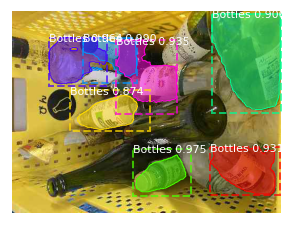

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


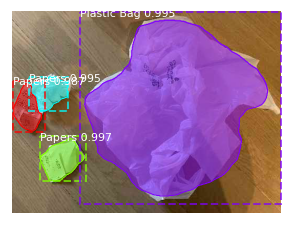

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


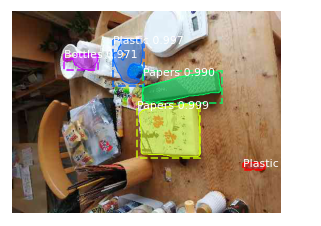

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


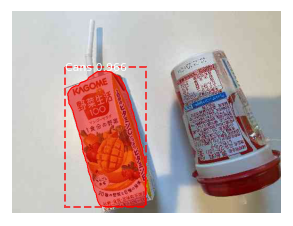

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


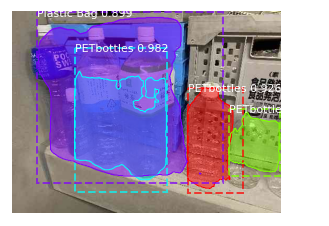

Processing 1 images
image                    shape: (384, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


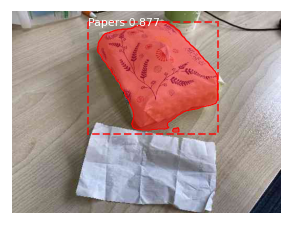

In [95]:
import skimage
real_test_dir = '../datasets/garbage/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))